# Модель прогнозирования стоимости жилья для агентства недвижимости

## 1. Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
df = pd.read_csv('data.csv')
print(df.shape)
df.head(5)

(377185, 18)


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [4]:
#Проверка на наличие дубликатов
dupl_columns = list(df.columns)
mask = df.duplicated(subset=dupl_columns)
df_duplicates = df[mask]
print(f'число найденных дубликатов: {df_duplicates.shape[0]}')

число найденных дубликатов: 50


In [5]:
#Удаление дубликатов
df = df.drop_duplicates(ignore_index=True)

In [6]:
#Проверка на удаление дубликатов. 
df_dedupped = df.drop_duplicates(subset=dupl_columns)
print(f'результирующее число записей: {df_dedupped.shape[0]}')

результирующее число записей: 377135


In [7]:
#Поиск столбцов с пропусками
cols_null_percent = df.isnull().mean()*100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
print(cols_with_null)

private pool    98.891378
mls-id          93.386453
PrivatePool     89.311520
fireplace       72.659393
stories         39.952272
baths           28.188315
beds            24.196640
MlsId           17.730786
sqft            10.752118
status          10.584274
propertyType     9.209699
target           0.657589
city             0.009015
street           0.000530
dtype: float64


Краткий вывод: Исходя из данных представленных выше, выявлены столбцы с наибольшим количеством пропусков: private pool, mls-id, PrivatePool. Столбцы с таким количеством пропусков не дают полезной информации при прогнозировании, от таких столбцов необходимо избавляться.

In [8]:
#Поиск неинформативных признаков
low_information_cols = []

for col in df.columns:
    top_freq = df[col].value_counts(normalize = True).max()
    nunique_ratio = df[col].nunique() / df[col].count()
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')
        
    

private pool: 100.0% одинаковых значений
mls-id: 99.86% уникальных значений


Краткий вывод: Столбец mls-id с 100% уникальныx значений не несет полезной информации, к нему же можно отнести столбец MlsId поскольку он содержит такие же данные, а именно уникальные идентификаторы MLS. Столбцы private pool и PrivatePool необходимо проверить на содержимое, тк наличие бассейна вседа влияет на стоимость недвижимости.

In [9]:
print(df['private pool'].unique())
print(df['PrivatePool'].unique())

[nan 'Yes']
[nan 'yes' 'Yes']


Краткий вывод: На основании полученных данных целесообразно создать новый признак - единый столбец о наличии бассейна pool_corr (наличие, отсуствие)

In [10]:

#Объединение столбцов, содержащих признаки наличия бассейна
df['pool_corr'] = df['private pool'].combine_first(df['PrivatePool'])
#Удаление столбцов с неинформативными признаками
df = df.drop(['PrivatePool', 'private pool', 'MlsId', 'mls-id'], axis=1)

#Приведение данных к единому виду, замена Nan на False, Yes на True
df['pool_corr'] = df['pool_corr'].fillna(False)
df['pool_corr'] = df['pool_corr'].replace(['yes', 'Yes'], True)
print("Уникальные значения 'pool_corr':", df['pool_corr'].unique())
display(df.head())

Уникальные значения 'pool_corr': [False  True]


,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,pool_corr
0,Active,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,"$418,000",False
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,"$310,000",False
2,for sale,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,"$2,895,000",True
3,for sale,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,"$2,395,000",False
4,for sale,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,"$5,000",False


In [11]:
display(df.head(3))
df.info()

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,pool_corr
0,Active,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,"$418,000",False
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,"$310,000",False
2,for sale,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,"$2,895,000",True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377135 entries, 0 to 377134
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337218 non-null  object
 1   propertyType  342402 non-null  object
 2   street        377133 non-null  object
 3   baths         270827 non-null  object
 4   homeFacts     377135 non-null  object
 5   fireplace     103111 non-null  object
 6   city          377101 non-null  object
 7   schools       377135 non-null  object
 8   sqft          336585 non-null  object
 9   zipcode       377135 non-null  object
 10  beds          285881 non-null  object
 11  state         377135 non-null  object
 12  stories       226461 non-null  object
 13  target        374655 non-null  object
 14  pool_corr     377135 non-null  bool  
dtypes: bool(1), object(14)
memory usage: 40.6+ MB


In [12]:
#Проверка на дубликаты
dupl_columns = list(df.columns)
mask = df.duplicated(subset=dupl_columns)
df_duplicates = df[mask]
print(f'число найденных дубликатов: {df_duplicates.shape[0]}')

число найденных дубликатов: 91


In [13]:
#Удаление дубликатов
df = df.drop_duplicates(ignore_index=True)
df_dedupped = df.drop_duplicates(subset=dupl_columns)
print(f'результирующее число записей: {df_dedupped.shape[0]}')

результирующее число записей: 377044


Краткий вывод: После обработки неинформативных признаков необходимо проверить и обработать все остальные имеющиеся признаки.

Признак: Status

In [14]:
#Поиск пустых и уникальных значений
empty = df.status.isnull().sum()

print(f'Количество пропущенных значений: {empty}\n'
      f'Количество уникальных значений: {df.status.nunique()}\n'
      f'Уникальные значения: {list(df.status.unique()[:15])}')
      

Количество пропущенных значений: 39916
Количество уникальных значений: 159
Уникальные значения: ['Active', 'for sale', nan, 'New construction', 'New', 'For sale', 'Pending', 'P', 'Active/Contingent', 'Pre-foreclosure / auction', ' / auction', 'Under Contract', 'Under Contract   Showing', 'Pre-foreclosure', 'Under Contract Backups']


In [15]:
#Группировка уникальных значений
groups_status = {
    "For Sale": ["for sale", "For sale", "New construction", "New", "Back on Market", "Back On Market"],
    "Active": [
        "Active", "A Active", "Active/Contingent", "Active Under Contract", "Active Option", "Auction - Active",
        "Active With Contingencies", "Active Option Contract", "Active Contingency", "Active Backup",
        "Active Contingent", "Active - Auction", "Active With Offer", "Active - Contingent", "Active with Contract",
        "Temporary Active", "Re Activated", "Reactivated", "Auction"
    ],
    "Pending": [
        "P", "Pending", "pending", "P Pending Sale", "Pending Ab", "Pending Continue To Show",
        "Pending Inspection", "Pending Offer Approval", "Pending In", "Pending W/Insp Finance", "Pending Fe",
        "Pending W/Backup Wanted", "Pending Backups Wanted", "Pending With Contingencies", "Lease/Purchase Pending",
        "Pending Bring Backup", "Pending - Taking Backups", "Pending - Continue to Show",
        "Pending Taking Backups", "Offer Pending Signature", "Pending (Do Not Show)", "Pending W/ Cont.",
        "Pending W/Escape Clause", "Pending - Backup Offer Requested", "Pending Sale"
    ],
    "Contingent": [
        "Contingent", "Contingent Finance And Inspection", "Contingent Show",
        "Contingent Take Backup", "Contingent - Sale of Home", "Contingent Finance and Inspection",
        "C Continue Show", "Contingent   Show", "Contingent   Release", "Contingent   No Show",
        "CT Insp - Inspection Contingency", "Contingent   Foreclosure", "Conting Accpt Backups",
        "Contingent - Financing", "Contingency 48 Hr (+/ )", "Contingency Contract", "Contingent Escape"
    ],
    "Foreclosure": [
        "Pre-foreclosure", "Pre-foreclosure / auction", " / auction", "Foreclosed", "foreclosure", "Foreclosure"
    ],
    "Under Contract": [
        "Under Contract", "Under Contract   Showing", "Under Contract Backups", "Under Contract Show",
        "Under Contract - Show", "Under Contract - No Show", "Under contract", "U Under Contract",
        "Due Diligence Period", "Contract Contingent On Buyer Sale", "Contract P", "Ct", "Uc Continue To Show",
        "Under Contract Taking Back Up Offers", "Under Contract W/ Bckp", "Contract"
    ],
    "For Rent": ["for rent", "Apartment for rent", "Condo for rent"],
    "Recently Sold": ["recently sold"],
    "Price Change": ["Price Change"],
    "Closed": ["Closed"],
    "Listing Extended": ["Listing Extended"],
    "Coming Soon": [
        "Coming soon: Nov 21.", "Coming soon: Dec 4.", "Coming soon: Nov 23.", "Coming soon: Nov 29.",
        "Coming soon: Dec 2.", "Coming soon: Dec 10.", "Coming soon: Dec 24.", "Coming soon: Nov 14.",
        "Coming soon: Nov 22.", "Coming soon: Oct 21.", "Coming soon: Dec 14.", "Coming soon: Oct 24.",
        "Coming soon: Dec 18.", "Coming soon: Dec 16.", "Coming soon: Dec 3.", "Coming soon: Dec 25.",
        "Coming soon: Nov 11.", "Coming soon: Nov 28.", "Coming soon: Nov 17.", "Coming soon: Dec 6.",
        "Coming soon: Nov 27.", "Coming soon: Nov 26.", "Coming soon: Dec 7.", "Coming soon: Dec 27.",
        "Coming soon: Dec 11.", "Coming soon: Dec 5.", "Coming soon: Nov 13.", "Coming soon: Nov 19.",
        "Coming soon: Nov 8.", "Coming soon: Oct 29.", "Coming soon: Dec 15.", "Coming soon: Oct 30.",
        "Coming soon: Dec 9.", "Coming soon: Dec 20.", "Coming soon: Dec 13.", "Coming soon: Dec 23.",
        "Coming soon: Nov 30.", "Coming soon: Dec 1.", "Coming soon: Nov 5.", "Coming soon: Nov 12.",
        "Coming soon: Nov 25.", "Coming soon: Nov 9."
    ],
}

def exchange_status(value):
    for group, status_values in groups_status.items():
        if value in status_values:
            return group
    return "Therest"

df['status'] = df['status'].apply(exchange_status)

In [16]:
#Проверка количества значений признака
empty = df.status.isnull().sum()

print(f'Количество пропущенных значений: {empty}\n'
      f'Количество уникальных значений: {df.status.nunique()}\n'
      f'Уникальные значения: {list(df.status.unique()[:15])}')

Количество пропущенных значений: 0
Количество уникальных значений: 13
Уникальные значения: ['Active', 'For Sale', 'Therest', 'Pending', 'Foreclosure', 'Under Contract', 'For Rent', 'Contingent', 'Price Change', 'Recently Sold', 'Coming Soon', 'Closed', 'Listing Extended']


In [17]:
#Проверка на дубликаты
dupl_columns = list(df.columns)
mask = df.duplicated(subset=dupl_columns)
df_duplicates = df[mask]
print(f'число найденных дубликатов: {df_duplicates.shape[0]}')

число найденных дубликатов: 0


Краткий вывод: признак предобработан

Признак: PropertyType

In [18]:
#Поиск пустых и уникальных значений
empty = df.propertyType.isnull().sum()

print(f'Количество пропущенных значений: {empty}\n'
      f'Количество уникальных значений: {df.propertyType.nunique()}\n'
      f'Уникальные значения: {list(df.propertyType.unique()[:15])}')


Количество пропущенных значений: 34725
Количество уникальных значений: 1280
Уникальные значения: ['Single Family Home', 'single-family home', 'lot/land', 'townhouse', 'Florida', nan, 'Single Family', 'coop', 'English', '2 Story', 'Townhouse', 'multi-family', 'Penthouse, Split-Level', 'Multi-Family Home', 'Condo']


In [19]:
#Приведение данных к одному регистру для сокращения идентичных уникальных значений с символами разного регистра
df.propertyType = df.propertyType.str.lower()
empty = df.propertyType.isnull().sum()

print(f'Количество пропущенных значений: {empty}\n'
      f'Количество уникальных значений: {df.propertyType.nunique()}\n'
      f'Уникальные значения: {list(df.propertyType.unique()[:15])}')


Количество пропущенных значений: 34725
Количество уникальных значений: 1272
Уникальные значения: ['single family home', 'single-family home', 'lot/land', 'townhouse', 'florida', nan, 'single family', 'coop', 'english', '2 story', 'multi-family', 'penthouse, split-level', 'multi-family home', 'condo', 'land']


In [20]:
#Приведение типа недвижимости single family к единому виду
df.propertyType = df.propertyType \
.str.replace('single-family home','single family') \
.str.replace('single family home','single family') 

#Создание нового признака Typeofproperty с обработанными данными
df['Typeofproperty'] = df['propertyType'].str.split(',').str[0]

In [21]:
#Проверка количества значений признака
empty = df.Typeofproperty.isnull().sum()

print(f'Количество пропущенных значений: {empty}\n'
      f'Количество уникальных значений: {df.Typeofproperty.nunique()}\n'
      f'Уникальные значения: {list(df.Typeofproperty.unique()[:15])}')


Количество пропущенных значений: 34725
Количество уникальных значений: 257
Уникальные значения: ['single family', 'lot/land', 'townhouse', 'florida', nan, 'coop', 'english', '2 story', 'multi-family', 'penthouse', 'multi-family home', 'condo', 'land', 'condo/townhome/row home/co-op', ' ']


In [22]:
#Группировка уникальных значений по общим типам недвижимости
groups_property = {
    'single_family_home': [
        'single family', '1 story', '2 story', 'detached', '1 story/ranch', '1 story traditional', 'single detached', 'singlefamilyresidence', 'single wide', 'single-wide mobile with land',
        'two story', 'one story', 'one level unit', 'rancher', '1 1/2 story', 'single wide mh', 'one story traditional'],
    'multi_family_home': [
        'multi-family', 'multi-family home', 'duplex', 'triplex', 'fourplex', 'multi_level', 'multi family', '2 unit condo', '2-story'],
    'condo': [
        'condo', 'coop', 'cooperative', 'condo/townhome/row home/co-op', 'condo/townhome', 'condominium', 'condo/unit', 'apartment/condo/townhouse', 'co-op', '2 story condo', 'high rise'],
    'townhouse': [
        'townhouse', 'townhome style', 'townhouse-interior', 'townhouse-end unit'],
    'apartment': [
        'apartment', 'condominium (single level)', 'high-rise', 'mid-rise', 'low-rise (1-3 stories)', 'Flats', 'studio'],
    'land': [
        'lot/land', 'land'],
    'mobile_home': [
        'mobile/manufactured', 'mobile / manufactured', 'manufactured house', 'mfd/mobile home', 'mobile home', 'manufactured home', 'manufactured double-wide', 'manufactured single-wide', 'mobile home 1 story', 'mobile manu - double wide'],
    'miscellaneous': [
        'miscellaneous'],
    'ranch': [
        'ranch', 'one story'],
    'modern': [
        'contemporary', 'contemporary/modern', "modern", 'mid-century modern', 'modern farmhouse', 'modernist'],
    'historical': [
        'historical', 'designated historical home', 'historical/conservation district', 'historic/older', 'historic vintage', 'historic'],
}


def exchange_property(value):
    for group, property_values in groups_property.items():
        if value in property_values:
            return group
    return "therest"

df['Typeofproperty'] = df['Typeofproperty'].apply(exchange_property)

In [23]:
#Проверка количества значений признака
empty = df.Typeofproperty.isnull().sum()

print(f'Количество пропущенных значений: {empty}\n'
      f'Количество уникальных значений: {df.Typeofproperty.nunique()}\n'
      f'Уникальные значения: {list(df.Typeofproperty.unique()[:15])}')


Количество пропущенных значений: 0
Количество уникальных значений: 12
Уникальные значения: ['single_family_home', 'land', 'townhouse', 'therest', 'condo', 'multi_family_home', 'mobile_home', 'apartment', 'modern', 'miscellaneous', 'ranch', 'historical']


In [24]:
#Удаление неактуального признака propertyType
df.drop('propertyType', axis=1, inplace=True)

Краткий вывод: признак предобработан

Признак: Street

In [25]:
#Удаление признака, тк в признаке много неопределенных адресов, он не будет являться информативным
df = df.drop(columns=['street'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377044 entries, 0 to 377043
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   status          377044 non-null  object
 1   baths           270782 non-null  object
 2   homeFacts       377044 non-null  object
 3   fireplace       103110 non-null  object
 4   city            377012 non-null  object
 5   schools         377044 non-null  object
 6   sqft            336508 non-null  object
 7   zipcode         377044 non-null  object
 8   beds            285839 non-null  object
 9   state           377044 non-null  object
 10  stories         226460 non-null  object
 11  target          374564 non-null  object
 12  pool_corr       377044 non-null  bool  
 13  Typeofproperty  377044 non-null  object
dtypes: bool(1), object(13)
memory usage: 37.8+ MB


Краткий вывод: признак удален

Признак:Baths

In [26]:
#Поиск пустых и уникальных значений
empty = df.baths.isnull().sum()

print(f'Количество пропущенных значений: {empty}\n'
      f'Количество уникальных значений: {df.baths.nunique()}\n'
      f'Уникальные значения: {list(df.baths.unique()[:15])}')


Количество пропущенных значений: 106262
Количество уникальных значений: 229
Уникальные значения: ['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3', 'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5', '1,000', '7 Baths', '2.0']


In [27]:
#Удаление всех слов,буквы, пробелов и двоеточий
df.baths = df.baths.str.replace('[a-zA-Z:]','', regex=True)
df.baths = df.baths.str.replace(' ','', regex=True)

In [28]:
#Проверка количества значений признака
empty = df.baths.isnull().sum()

print(f'Количество пропущенных значений: {empty}\n'
      f'Количество уникальных значений: {df.baths.nunique()}\n'
      f'Уникальные значения: {list(df.baths.unique()[:15])}')

Количество пропущенных значений: 106262
Количество уникальных значений: 148
Уникальные значения: ['3.5', '3', '2', '8', nan, '1,750', '4', '5', '1,000', '7', '2.0', '3.0', '1', '4.0', '2.1']


In [29]:
#Исправление и приведение данных к единому виду
df['baths'] = df['baths'].str.replace('[a-zA-Z+:]','', regex=True)
df['baths'].replace(['nan','', '~', '..', '--', '—','0.0','0.00','0/0'], 0, inplace=True)
df['baths'].replace(['1-2','1/1-0/1-0/1-0', '1/1/1/1','1-0/1-0/1', ], 1, inplace=True)
df['baths'].replace(['2-1/2-1/1-1/1-1','3-1/2-2',], 2, inplace=True)
df['baths'].replace(['116/116/116'], 116, inplace=True)
df['baths'].replace(['7,500'], 7.5, inplace=True)
df['baths'].replace(['5,000'], 5, inplace=True)
df['baths'].replace(['3,500'], 3.5, inplace=True)
df['baths'].replace(['2,750'], 2.75, inplace=True)
df['baths'].replace(['2,250'], 2.25, inplace=True)
df['baths'].replace(['1,250'], 1.25, inplace=True)
df['baths'].replace(['1,500'], 1.5, inplace=True)
df['baths'].replace(['4,000'], 4, inplace=True)
df['baths'].replace(['2,000'], 2, inplace=True)
df['baths'].replace(['3,000'], 3, inplace=True)
df['baths'].replace(['2,500'], 2.5, inplace=True)
df['baths'].replace(['1,000'], 1, inplace=True)
df['baths'].replace(['1,750'], 1.75, inplace=True)
df['baths'] = df['baths'].fillna(0)

In [30]:
#Перевод признака в числовой тип и округление до целого числа
df['baths'] = df['baths'].astype(float).round()

In [31]:
#Выбор строк по следующим условиям
selected_rows = df[(df['baths'] == 0) & ((df['Typeofproperty'] == 'other') | (df['Typeofproperty'] == 'land') | (df['Typeofproperty'] == 'ranch'))]
display(selected_rows.head(3))

#Определение и вывод процента выбранных строк от общего числа строк по условиям сформированным выше
percent_selected = len(selected_rows) / len(df) * 100
print(f"Процент выбранных строк от общего числа строк: {percent_selected:.2f}%")

,status,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,pool_corr,Typeofproperty
4,For Sale,0.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,"$5,000",False,land
41,For Sale,0.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,San Diego,"[{'rating': ['9/10', '9/10', '9/10'], 'data': ...",NaN,92127,NaN,CA,NaN,"$1,100,000",False,land
49,Active,0.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Glendale,"[{'rating': ['8', '9', '7', '8', '9', '7', 'NR...",0,85310,NaN,AZ,NaN,"$275,000",False,land


Процент выбранных строк от общего числа строк: 8.58%


In [32]:
#Выбор строк по следующим условиям
selected_rows = df[(df['baths'] == 0) & ~(df['Typeofproperty'].isin(['other', 'land', 'ranch']))]
display(selected_rows.head(3))

#Поиск уникальных значений признака status в выбранных строках
unique_statuses = selected_rows['Typeofproperty'].unique()

#Вывод полученных строк и процента выбранных строк
print(f"Уникальные значения признака Typeofproperty в выбранных строках: {unique_statuses}")
percent_selected = len(selected_rows) / len(df) * 100
print(f"Процент выбранных строк от общего числа строк: {percent_selected:.2f}%")

,status,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,pool_corr,Typeofproperty
5,For Sale,0.0,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,19145,2 Beds,PA,2.0,"$209,000",False,townhouse
6,Active,0.0,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,POINCIANA,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...","1,507",34759,NaN,FL,One,"181,500",False,therest
7,Active,0.0,"{'atAGlanceFacts': [{'factValue': '1976', 'fac...",NaN,Memphis,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",NaN,38115,NaN,TN,NaN,"68,000",False,therest


Уникальные значения признака Typeofproperty в выбранных строках: ['townhouse' 'therest' 'single_family_home' 'condo' 'apartment' 'modern'
 'miscellaneous' 'multi_family_home' 'mobile_home' 'historical']
Процент выбранных строк от общего числа строк: 21.04%


In [33]:
#Проверка количества значений признака
empty = df.baths.isnull().sum()

print(f'Количество пропущенных значений: {empty}\n'
      f'Количество уникальных значений: {df.baths.nunique()}\n'
      f'Уникальные значения: {list(df.baths.unique()[:15])}')


Количество пропущенных значений: 0
Количество уникальных значений: 49
Уникальные значения: [4.0, 3.0, 2.0, 8.0, 0.0, 5.0, 1.0, 7.0, 6.0, 9.0, 12.0, 750.0, 10.0, 19.0, 18.0]


Краткий вывод: признак предобработан

Признак: homeFacts

In [34]:
#Поиск пустых и уникальных значений
empty = df.homeFacts.isnull().sum()

print(f'Количество пропущенных значений: {empty}\n'
      f'Количество уникальных значений: {df.homeFacts.nunique()}\n'
      f'Уникальные значения: {list(df.homeFacts.unique()[:1])}')

Количество пропущенных значений: 0
Количество уникальных значений: 321009
Уникальные значения: ["{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"]


In [35]:
#Значения factLabel

label = df.homeFacts.str.findall(r"\bfactLabel': ([\s\S]+?)[}\b]")
label[15]

["'Year built'",
 "'Remodeled year'",
 "'Heating'",
 "'Cooling'",
 "'Parking'",
 "'lotsize'",
 "'Price/sqft'"]

In [36]:
#Значения factValue
Value = df.homeFacts.str.findall(r"\bfactValue': ([\s\S]+?), 'factLabel\b")
Value[:15]

0     ['2019', '', 'Central A/C, Heat Pump', '', '',...
1     ['2019', '', '', '', '', '5828 sqft', '$159/sq...
2     ['1961', '1967', 'Forced Air', 'Central', 'Att...
3     ['2006', '2006', 'Forced Air', 'Central', 'Det...
4             ['', '', '', '', '', '10,019 sqft', None]
5     ['1920', '', 'Forced Air', 'Central', '', '680...
6     ['2006', '2006', 'Electric, Heat Pump', 'Centr...
7     ['1976', '', '', '', '', '8,750 Sq. Ft.', '$57...
8     ['1970', '', 'Forced Air', 'Central', '', '124...
9     ['2019', None, 'Gas', 'Central', 'Attached Gar...
10    ['1965', '', '', '', 'Attached Garage', '1.73 ...
11    ['2015', '2015', 'Central Electric', 'Central ...
12    ['1996', '1997', 'Forced Air', 'Central', 'Car...
13    ['2019', '2019', 'Forced air', '', 'Attached G...
14    ['1982', '1982', 'Other', 'Central', '2 spaces...
Name: homeFacts, dtype: object

In [37]:
#Создание списка названий признаков, удаление кавычек
list_label = ','.join(label[0]).replace("'","").split(',')
list_label

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [38]:
#Дополнение признаками датасета и заполнение значениями
for i, val in enumerate(list_label):
    df[val]=Value.apply(lambda x: x[i])

In [39]:
##Удаление неактуального признака homeFacts
df = df.drop('homeFacts', axis=1)

Краткий вывод: признак homeFacts по условиям задачи представлял собой словарь и содержал несколько типов сведений. Признак был десериализован и удален,а из него были созданы новые признаки, которые также потребуют обработки: Year built','Remodeled year','Heating','Cooling','Parking','lotsize','Price/sqft'

Признак: Year built

In [40]:
#Удаление ненужных кавычек
df['Year built'] = df['Year built'].str.replace("'",'', regex=True)
#Вывод уникальных значений
df['Year built'].sort_values().unique()[:15]

array(['', '1', '1019', '1057', '1060', '1208', '1700', '1703', '1735',
       '1740', '1750', '1780', '1788', '1790', '1794'], dtype=object)

In [41]:
#Замена кавычек и некорректных значений на 'no date'
df['Year built'] = df['Year built'].str.replace('^\s*$','no date', regex=True)
mask= df['Year built'].isin(['1','1208','559990649990','2025','No Data','None'])
df.loc[mask,'Year built'] = 'no date'
#Исправление некорретного отображения года, ввиду очевидных опечаток 
df.loc[df['Year built']=='1019','Year built'] = '1919'
df.loc[df['Year built']=='1057','Year built'] = '1957'
df.loc[df['Year built']=='1060','Year built'] = '1960'

df['Year built'].sort_values().unique()[:15]

array(['1700', '1703', '1735', '1740', '1750', '1780', '1788', '1790',
       '1794', '1795', '1796', '1799', '1800', '1802', '1803'],
      dtype=object)

In [42]:
#Выбор строк по следующим условиям
selected_rows = df[(df['Year built'] == 'no date') & ((df['Typeofproperty'] == 'other') | (df['Typeofproperty'] == 'land') | (df['Typeofproperty'] == 'ranch'))]

display(selected_rows.head(5))

print(f"Выбранных строк: {len(selected_rows)}")


,status,baths,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,pool_corr,Typeofproperty,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
4,For Sale,0.0,NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,"$5,000",False,land,no date,'','','','',"'10,019 sqft'",None
41,For Sale,0.0,NaN,San Diego,"[{'rating': ['9/10', '9/10', '9/10'], 'data': ...",NaN,92127,NaN,CA,NaN,"$1,100,000",False,land,no date,'','','','','9.25 acres',None
49,Active,0.0,NaN,Glendale,"[{'rating': ['8', '9', '7', '8', '9', '7', 'NR...",0,85310,NaN,AZ,NaN,"$275,000",False,land,no date,'','','','','50530',None
50,For Sale,0.0,NaN,Palm Coast,"[{'rating': ['4/10', '5/10', '4/10'], 'data': ...",NaN,32164,NaN,FL,NaN,"$27,000",False,land,no date,'','','','','10018 sqft',None
70,For Sale,0.0,NaN,Waco,"[{'rating': ['3/10', '2/10', '2/10', '5/10'], ...",NaN,76705,NaN,TX,NaN,"$10,000",False,land,no date,'','','','','',None


Выбранных строк: 26929


In [43]:
#Выбор строк по следующим условиям
selected_rows = df[(df['Year built'] == 'no date') & ~(df['Typeofproperty'].isin(['other', 'land', 'ranch']))]
display(selected_rows.head(5))

#Поиск уникальных значений признака status в выбранных строках
unique_statuses = selected_rows['Typeofproperty'].unique()
print(f"Уникальные значения признака Typeofproperty в выбранных строках: {unique_statuses}")
print(f"Выбранных строк: {len(selected_rows)}")

,status,baths,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,pool_corr,Typeofproperty,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
26,Active,1.0,NaN,Miami,"[{'rating': ['9', '10', 'NR', '6', '3'], 'data...",NaN,33183,Baths,FL,NaN,"799,000",False,therest,no date,'','','','','—',None
27,For Sale,3.0,NaN,Houston,"[{'rating': ['6/10', '9/10', '3/10'], 'data': ...","2,575 sqft",77018,3 Beds,TX,NaN,"$499,900",False,single_family_home,no date,'','','','','3828 sqft','$194/sqft'
40,Active,0.0,NaN,ROTONDA WEST,"[{'rating': ['6', '6', '7'], 'data': {'Distanc...",NaN,33947,NaN,FL,NaN,"54,000",False,therest,no date,'','','','','—',None
42,Active,0.0,NaN,New York,"[{'rating': ['NR', 'NR', '9', '8', '8', '2', '...",NaN,10006,NaN,NY,NaN,"850,000",False,therest,no date,'2003','','','','—',None
48,Active,0.0,NaN,Signal Mountain,"[{'rating': ['8', 'NR', '7', '4'], 'data': {'D...",NaN,37377,NaN,TN,NaN,"125,000",False,therest,no date,'','','','','—',None


Уникальные значения признака Typeofproperty в выбранных строках: ['therest' 'single_family_home' 'townhouse' 'condo' 'miscellaneous'
 'multi_family_home' 'apartment' 'mobile_home' 'modern']
Выбранных строк: 36555


In [44]:
#Проверка количества значений признака
empty = df['Year built'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {df['Year built'].nunique()}\n"
      f"Уникальные значения: {list(df['Year built'].unique()[:15])}")

Количество пропущенных значений: 0
Количество уникальных значений: 222
Уникальные значения: ['2019', '1961', '2006', 'no date', '1920', '1976', '1970', '1965', '2015', '1996', '1982', '1905', '2008', '1899', '2016']


Краткий вывод: признак предобработан

Признак: Remodeled year

In [45]:
#Удаление ненужных кавычек
df['Remodeled year'] = df['Remodeled year'].str.replace("'",'', regex=True)

df['Remodeled year'].sort_values().unique()[:15]

array(['', '0', '1111', '1738', '1800', '1845', '1846', '1853', '1862',
       '1869', '1870', '1874', '1876', '1877', '1880'], dtype=object)

In [46]:
#Замена некорректных значений, не относящихся к реальным годам на None
mask= df['Remodeled year'].isin(['', '0', '1111'])
df.loc[mask,'Remodeled year'] = 'None'
#Проверка произведенной замены
print(df['Remodeled year'].sort_values().unique()[:15])

['1738' '1800' '1845' '1846' '1853' '1862' '1869' '1870' '1874' '1876'
 '1877' '1880' '1883' '1884' '1885']


In [47]:
#Проверка количества значений признака
empty = df['Remodeled year'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {df['Remodeled year'].nunique()}\n"
      f"Уникальные значения: {list(df['Remodeled year'].unique()[:15])}")

Количество пропущенных значений: 0
Количество уникальных значений: 152
Уникальные значения: ['None', '1967', '2006', '2015', '1997', '2019', '1982', '1905', '2009', '2007', '1996', '1995', '1988', '1972', '1949']


In [48]:
#Проверка количества None в процентах от общего количества данных по признаку
print(f"Процент None: {round(df[df['Remodeled year']=='None'].shape[0]/df.shape[0]*100, 2)}%")


Процент None: 60.0%


In [49]:
#Удаление признака, поскольку None более 60%, следовательно признак неинформативен.
df = df.drop('Remodeled year', axis=1)

Краткий вывод: признак предобработан

Признак: Heating

In [50]:
#Приведение данных к одному регистру, анализ признака
print(df['Heating'].str.lower().value_counts().head(15))

Heating
'forced air'           134307
''                     105672
'other'                 29622
'electric'              10216
'gas'                    9295
'heat pump'              8851
'no data'                8610
'central air'            7814
'central electric'       7112
'central'                6247
'central, electric'      4253
'baseboard'              3815
none                     3533
'wall'                   3301
'electric heat'          3064
Name: count, dtype: int64


In [51]:
#Отопление отсутсвует в передвижных домах, и на пустях участках 
#Выявление процента для признаков land и mobile_home
land_percentage = (df['Typeofproperty'].value_counts().loc['land'] / len(df)) * 100
mobile_home_percentage = (df['Typeofproperty'].value_counts().loc['mobile_home'] / len(df)) * 100


print("Процент значений 'land' и 'mobile_home': {:.2f} %".format(land_percentage + mobile_home_percentage))

Процент значений 'land' и 'mobile_home': 9.27 %


In [52]:
#Удаление ненужных ковычек
df['Heating'] = df['Heating'].str.replace("'",'', regex=True)
df['Heating_corr'] = df['Heating'].apply(lambda x: True if x not in ['', 'no data', 'None', 'none'] else False)

In [53]:
#Проверка количества значений признака
empty = df['Heating_corr'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {df['Heating_corr'].nunique()}\n"
      f"Уникальные значения: {list(df['Heating_corr'].unique()[:15])}")

Количество пропущенных значений: 0
Количество уникальных значений: 2
Уникальные значения: [True, False]


In [54]:
#Удаление неактуального признака Heating
df= df.drop('Heating', axis=1)

Краткий вывод: признак предобработан

Признак: Cooling

In [55]:
#Приведение данных к одному регистру, анализ признака
df['Cooling'].str.lower().value_counts().head(20)

Cooling
'central'                                            158742
''                                                   120308
'central air'                                         14384
'no data'                                             10615
'has cooling'                                          9730
'none'                                                 7390
'central electric'                                     6154
'wall'                                                 4017
'central gas'                                          3573
none                                                   3533
'central heating'                                      2807
'cooling system'                                       2699
'central a/c'                                          2051
'other'                                                1840
'central a/c (electric), central heat (gas)'           1646
'central a/c (electric), central heat (electric)'      1429
'refrigeration'                 

In [56]:
#Предполагаем, что в строках, где кавычки пустые скорее всего нет кондиционера
#Удаление лишних кавычек, создание нового признака Cooling_corr со скорректированными значениями
df['Cooling'] = df['Cooling'].str.replace("'",'', regex=True)
df['Cooling_corr'] = df['Cooling'].apply(lambda x: True if x not in ['', 'no data', 'None', 'none'] else False)
#Удаление неактуального признака Cooling
df= df.drop('Cooling', axis=1)

Краткий вывод: признак предобработан

Признак: Parking

In [57]:
#Приведение данных к одному регистру, анализ признака
df['Parking'].str.lower().value_counts().head(20)

Parking
''                                    171757
'attached garage'                      70748
'2 spaces'                             28061
'1 space'                              14252
'no data'                              13332
'detached garage'                      13200
'carport'                               7743
'off street'                            5279
'3 spaces'                              4724
none                                    3533
'carport, attached garage'              3025
'1'                                     2936
'4 spaces'                              2917
'2'                                     2756
'none'                                  2368
'on street'                             1707
'attached garage, detached garage'      1354
'0'                                     1114
'attached garage, carport'               993
'parking desc'                           900
Name: count, dtype: int64

In [58]:
#Предполагаем, что в строках, где кавычки пустые скорее всего нет паркинга
#Удаление лишних кавычек, создание нового признака Parking_corr со скорректированными значениями
df['Parking'] = df['Parking'].str.replace("'",'', regex=True)
df['Parking_corr'] = df['Parking'].apply(lambda x: True if x not in ['', 'no data', 'None', 'none','0'] else False)

#Удаление неактуального признака Parking
df = df.drop('Parking', axis=1)

Краткий вывод: признак предобработан

Признак: Lotsize

In [59]:
#Приведение данных к одному регистру, анализ признака
df['lotsize'].str.lower().value_counts().head(20)

lotsize
''               33055
none             28346
'—'              25247
'no data'         5329
'-- sqft lot'     3819
'0.26 acres'      3140
'0.25 acres'      2722
'0.28 acres'      2614
'0.27 acres'      2473
'0.29 acres'      2351
'0.34 acres'      1953
'0.31 acres'      1720
'0.32 acres'      1582
'6,098 sqft'      1525
'0.3 acres'       1436
'0.33 acres'      1412
'7,405 sqft'      1357
'0.35 acres'      1356
'1 acre'          1347
'6,534 sqft'      1292
Name: count, dtype: int64

In [60]:
#Признак не полезен, много пропусков, к удалению
df = df.drop('lotsize', axis=1)

Краткий вывод: признак удален

Признак: Price/sqft

In [61]:
#Признак 'Price/sqft' напрямую зависит от целевого признака, к удалению
df= df.drop('Price/sqft', axis=1)

Краткий вывод: признак удален

Признак: Fireplace

In [62]:
#Приведение данных к одному регистру, анализ признака
df['fireplace'].str.lower().value_counts().head(20)

fireplace
yes                     71209
1                       14543
2                        2432
not applicable           1993
fireplace                 847
3                         564
living room               433
location                  399
wood burning              311
gas/gas logs              300
no                        289
fireplace yn              287
special features          279
1 fireplace               274
0                         271
familyrm                  246
fireplace features        239
great room                207
wood                      206
gas logs, great room      188
Name: count, dtype: int64

In [63]:
#Корректировка данных признака с созданием нового признака fireplace_corr
df['fireplace_corr'] = df['fireplace'].apply(lambda x: True if x not in ['', 'no data', 'None', 'none', '0', 'not applicable', 'no'] and not pd.isna(x) else False)

#Удаление неактуального признака 'fireplace'
df.drop('fireplace', axis=1, inplace=True)

Краткий вывод: признак предобработан

Признак: City

In [64]:
#Приведение данных признака к единому виду
df['city'] = df['city'].str.title()

In [65]:
#Поиск пустых и уникальных значений
empty = df['city'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {df['city'].nunique()}\n"
      f"Уникальные значения: {list(df['city'].unique()[:15])}")

Количество пропущенных значений: 32
Количество уникальных значений: 1909
Уникальные значения: ['Southern Pines', 'Spokane Valley', 'Los Angeles', 'Dallas', 'Palm Bay', 'Philadelphia', 'Poinciana', 'Memphis', 'Mason City', 'Houston', 'Flushing', 'Pembroke Pines', 'Eugene', 'Brooklyn', 'Fort Lauderdale']


In [66]:
#Приведение данных к одному регистру, анализ признака
df['city'].str.lower().value_counts().sort_index().head(20)

city
                  25
--                 9
abilene          134
abingdon         116
accokeek           3
adams              5
addison           25
adel              13
adelphi            6
advance            3
akron            108
alamo heights     84
albany           420
albion             4
alburgh           28
alden              6
aledo             60
alexandria       136
algona             2
alhambra          58
Name: count, dtype: int64

In [67]:
#Удаление слова Сity из названия городов
df['city'] = df['city'].str.replace(' City', '') 

#удаление строк, содержащих ' ', '--' или NaN в столбце 'city'. Определение количества удаленных строк
initial_row_count = df.shape[0]
df = df[~df['city'].isin([' ', '--', np.nan])]
removed_row_count = initial_row_count - df.shape[0]

print(f"Количество удаленных строк: {removed_row_count}")

Количество удаленных строк: 66


In [68]:
#Проверка количества значений признака
empty = df['city'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {df['city'].nunique()}\n"
      f"Уникальные значения: {list(df['city'].unique()[:15])}")

Количество пропущенных значений: 0
Количество уникальных значений: 1897
Уникальные значения: ['Southern Pines', 'Spokane Valley', 'Los Angeles', 'Dallas', 'Palm Bay', 'Philadelphia', 'Poinciana', 'Memphis', 'Mason', 'Houston', 'Flushing', 'Pembroke Pines', 'Eugene', 'Brooklyn', 'Fort Lauderdale']


Краткий вывод: признак предобработан

Признак: Schools

In [69]:
df.schools[20]

"[{'rating': ['3/10', '5/10'], 'data': {'Distance': ['2.9 mi', '1.7 mi'], 'Grades': ['K-8', '9-12']}, 'name': ['Alpine Elementary School', 'William J. (Pete) Knight High School']}]"

In [70]:
#Признак в соответствии с условиями задания представляет собой словарь и содержит несколько типов сведений. 
#В данном случае не понадобятся все сведения, а только расстояние до школы и рейтинг учебного заведения, из которых создаются новые признаки.

#Рассчет среднего рейтинга школы
def school_rating(rating):
    rating = rating[0].replace('/10', '')
    extracted_numbers = [float(num) for num in rating if num.isdigit()]
    average_rating = np.average(extracted_numbers) if extracted_numbers else -1
    return round(average_rating, 1)

s_rating = (
    df.schools.str.findall(r"\brating': ([\s\S]+?), 'data\b")
    .apply(lambda x: school_rating(x))
)

#Новый признак 'school_rating _mean' добавляется в датасет. Пропуски заполняются значением -1 
df['school_rating _mean'] = s_rating

In [71]:
#Расчет минимального расстояние
s_distance = df.schools.str.findall(r"\bDistance': ([\s\S]+?), 'Grades\b") 
#Извлечение расстояния до школы из каждой строки
s_distance = s_distance.apply(lambda x: x[0]) 
#Получение первого найденного значение списков, полученных в результате предыдущего шага
s_distance = s_distance.str.replace('[a-zA-Z]','', regex=True) 
#Удаление всех буквенных символов
s_distance = s_distance.str.findall(r'\b([0-9]+.[0-9]+)') 
#Извлечение числа в виде числа с точкой, включая десятичные значения
s_distance = s_distance.apply(lambda x: [float(i) for i in x]) 
#Конвертация каждого числовоого значения списка в тип float
school_dist_min = s_distance.apply(lambda x: -1 if len(x)==0 else min(x)) 
#Поиск минимального значения в каждом списке s_distance, и возвращение -1, если длина списка равна 0
#Новый признак 'school_distance_min' добавялется в датасет, пропуски заполняются значением -1
df['school_distance_min'] = school_dist_min

In [72]:
#Удаление неактуального признака schools
df.drop('schools', axis=1, inplace=True)

Краткий вывод: признак schools по условиям задачи представлял собой словарь и содержал несколько типов сведений. Признак был десериализован и удален, а из него были созданы новые признаки school_rating _mean и chool_distance_min

Признак: Sqft

In [73]:
#Поиск пустых и уникальных значений
empty = df['sqft'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {df['sqft'].nunique()}\n"
      f"Уникальные значения: {list(df['sqft'].unique()[:15])}")

Количество пропущенных значений: 40517
Количество уникальных значений: 25396
Уникальные значения: ['2900', '1,947 sqft', '3,000 sqft', '6,457 sqft', nan, '897 sqft', '1,507', '3588', '1,930', '1,300 sqft', '3,130', '2,839 sqft', 'Total interior livable area: 1,820 sqft', '2,454', '2,203']


In [74]:
#Обработка данных признака
s_sqft = df.sqft[df.sqft.notna()]
s_sqft = s_sqft.str.findall(r"\d+")
s_sqft = s_sqft.apply(lambda x: ''.join(x))
df.loc[df.sqft.notna(), 'sqft']=s_sqft
#Замена пропусков на "0"
df.sqft = df.sqft.fillna(0)
#Замена пустых строк на '0'
df.loc[df.sqft=='','sqft']=0
df.sqft = df.sqft.astype(int)

In [75]:
#Проверяем количества значений признака
empty = df['sqft'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {df['sqft'].nunique()}\n"
      f"Уникальные значения: {list(df['sqft'].unique()[:15])}")

Количество пропущенных значений: 0
Количество уникальных значений: 9890
Уникальные значения: [2900, 1947, 3000, 6457, 0, 897, 1507, 3588, 1930, 1300, 3130, 2839, 1820, 2454, 2203]


In [76]:
#Выбор строк по следующим условиям
selected_rows = df[(df['sqft'] == 0) & ((df['Typeofproperty'] == 'other') | (df['Typeofproperty'] == 'land') | (df['Typeofproperty'] == 'ranch'))]
display(selected_rows.head(5))
print(f"Выбранных строк: {len(selected_rows)}")



,status,baths,city,sqft,zipcode,beds,state,stories,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
4,For Sale,0.0,Palm Bay,0,32908,NaN,FL,NaN,"$5,000",False,land,no date,False,False,False,False,4.7,3.03
41,For Sale,0.0,San Diego,0,92127,NaN,CA,NaN,"$1,100,000",False,land,no date,False,False,False,False,9.0,0.97
49,Active,0.0,Glendale,0,85310,NaN,AZ,NaN,"$275,000",False,land,no date,False,False,False,False,8.0,0.70
50,For Sale,0.0,Palm Coast,0,32164,NaN,FL,NaN,"$27,000",False,land,no date,False,False,False,False,4.3,4.01
70,For Sale,0.0,Waco,0,76705,NaN,TX,NaN,"$10,000",False,land,no date,False,False,False,False,3.0,1.47


Выбранных строк: 27329


In [77]:
#Выбор строк по следующим условиям
selected_rows = df[(df['sqft'] == 0) & ~(df['Typeofproperty'].isin(['other', 'land', 'ranch']))]
display(selected_rows.head(5))

#Поиск уникальных значений признака status в выбранных строках
unique_statuses = selected_rows['Typeofproperty'].unique()
print(f"Уникальные значения признака Type в выбранных строках: {unique_statuses}")
print(f"Выбранных строк: {len(selected_rows)}")


,status,baths,city,sqft,zipcode,beds,state,stories,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
7,Active,0.0,Memphis,0,38115,NaN,TN,NaN,"68,000",False,therest,1976,False,False,False,False,2.7,0.4
15,For Sale,0.0,Brooklyn,0,11219,NaN,NY,NaN,"1,650,000",False,single_family_home,1905,False,True,False,False,6.3,0.2
26,Active,1.0,Miami,0,33183,Baths,FL,NaN,"799,000",False,therest,no date,False,False,False,False,3.8,0.9
40,Active,0.0,Rotonda West,0,33947,NaN,FL,NaN,"54,000",False,therest,no date,False,False,False,False,6.3,3.1
42,Active,0.0,New York,0,10006,NaN,NY,NaN,"850,000",False,therest,no date,False,False,False,False,7.0,0.1


Уникальные значения признака Type в выбранных строках: ['therest' 'single_family_home' 'condo' 'miscellaneous'
 'multi_family_home' 'townhouse' 'mobile_home' 'modern' 'apartment']
Выбранных строк: 25798


Краткий вывод: признак предобработан

Признак: Zipcode

In [78]:
#Поиск пустых и уникальных значений
empty = df['zipcode'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {df['zipcode'].nunique()}\n"
      f"Уникальные значения: {list(df['zipcode'].unique()[:15])}")

Количество пропущенных значений: 0
Количество уникальных значений: 4549
Уникальные значения: ['28387', '99216', '90049', '75205', '32908', '19145', '34759', '38115', '50401', '77080', '11354', '77068', '33028', '97401', '77084']


In [79]:
#Строки с некорретным написанием почтового индекса 
df[(df['zipcode']=='--') | (df['zipcode']=='0')| (df['zipcode']=='00000') ]

,status,baths,city,sqft,zipcode,beds,state,stories,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
30258,Active,0.0,Vacaville,0,0,NaN,CA,NaN,"$380,000",False,land,no date,False,False,False,False,3.7,6.50
83514,For Sale,0.0,Quito Ecuador,0,0,NaN,NY,NaN,"470,000",False,therest,1995,False,True,False,False,-1.0,-1.00
231230,For Sale,0.0,Bonsall,0,--,449 acres,CA,NaN,"$60,000,000",False,therest,no date,False,False,False,False,5.7,2.90
235154,Therest,3.0,Fort Lauderdale,2043,--,3,FL,NaN,"$425,000",False,townhouse,2010,True,True,True,False,5.0,0.50
305481,For Sale,0.0,Laredo,243849,0,NaN,TX,NaN,"$1,740,000",False,land,no date,False,False,False,False,4.0,7.45
308135,Active,0.0,Foreign Country,1100,00000,NaN,OS,NaN,"125,000",False,therest,1972,False,False,False,False,-1.0,-1.00


In [80]:
#Выбор строк по следующим условиям
indexes_to_drop = df[(df['zipcode']=='--') | (df['zipcode']=='0')| (df['zipcode']=='00000')].index

#Удаление выбранных строк
df = df.drop(indexes_to_drop)

In [81]:
df.zipcode.sort_values().unique()[:15]

array(['02108', '02109', '02110', '02111', '02113', '02114', '02115',
       '02116', '02118', '02119', '02120', '02121', '02122', '02124',
       '02125'], dtype=object)

In [82]:
#Корректировка некорректных zipcode, отбрасывается вторая часть
df.zipcode = df.zipcode.str.replace("-.+",'', regex=True)

df.zipcode.sort_values().unique()[:15]

array(['02108', '02109', '02110', '02111', '02113', '02114', '02115',
       '02116', '02118', '02119', '02120', '02121', '02122', '02124',
       '02125'], dtype=object)

Краткий вывод: признак предобработан

Признак: Beds

In [83]:
#Поиск пустых и уникальных значений
empty = df['beds'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {df['beds'].nunique()}\n"
      f"Уникальные значения: {list(df['beds'].unique()[:15])}")

Количество пропущенных значений: 91156
Количество уникальных значений: 1181
Уникальные значения: ['4', '3 Beds', '5 Beds', nan, '2 Beds', '3', '4 Beds', '3 bd', 'Baths', '4 bd', '5 bd', '8 Beds', '2', '2 bd', '2.0']


In [84]:
#Признак не информативен и не может быть использован тк, указаны как числа, так и beds, baths и тп
df = df.drop('beds', axis=1)

Краткий вывод: признак удален

Признак: State

In [85]:
#Поиск пустых и уникальных значений
empty = df['state'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {df['state'].nunique()}\n"
      f"Уникальные значения: {list(df['state'].unique()[:15])}")

Количество пропущенных значений: 0
Количество уникальных значений: 37
Уникальные значения: ['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR', 'DC', 'NV', 'AZ', 'GA', 'IL']


Краткий вывод: признак в предобработке не нуждается

Stories

In [86]:
#Поиск пустых и уникальных значений
empty = df['stories'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {df['stories'].nunique()}\n"
      f"Уникальные значения: {list(df['stories'].unique()[:15])}")

Количество пропущенных значений: 150517
Количество уникальных значений: 346
Уникальные значения: [nan, '2.0', '1.0', '3.0', 'One', '2', 'Multi/Split', '4.0', '0.0', '0', 'One Level', '1', '9.0', '3', '1 Level, Site Built']


In [87]:
#Проверка по какому типу нежвижимости пропуски по этажам
df[df.stories.isna()].Typeofproperty.value_counts()

Typeofproperty
single_family_home    46300
therest               37000
land                  28817
condo                 24355
multi_family_home      5212
townhouse              3937
mobile_home            1499
ranch                  1389
modern                 1129
apartment               824
historical               44
miscellaneous            11
Name: count, dtype: int64

In [88]:
#Ввиду множества пропусков в разныих типах недвижимости, признак неинформативен, удаляется
df = df.drop('stories', axis=1)

Краткий вывод: признак предобработан

Целевой признак: target

In [89]:
#Поиск пустых и уникальных значений
empty = df['target'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {df['target'].nunique()}\n"
      f"Уникальные значения: {list(df['target'].unique()[:15])}")

Количество пропущенных значений: 2475
Количество уникальных значений: 43937
Уникальные значения: ['$418,000', '$310,000', '$2,895,000', '$2,395,000', '$5,000', '$209,000', '181,500', '68,000', '$244,900', '$311,995', '$669,000', '260,000', '$525,000', '$499,900', '$168,800']


In [90]:
#Удаление строк с пропусками
df = df.dropna(subset=['target'])

In [91]:
#В признаке обнаружены значения,указывающие, что на оплату за месяц по арендованным к вартирам(с приставкой /мо- это аренда)
df[df.target.str.contains('/mo',regex=True)].head(5)

,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
547,For Rent,4.0,Chicago,3300,60618,IL,"$5,500/mo",False,single_family_home,1913,True,False,True,True,2.3,0.13
609,For Rent,2.0,Boston,1673,2116,MA,"$10,500/mo",False,multi_family_home,1985,False,False,False,True,-1.0,-1.00
2075,For Rent,4.0,Fort Lauderdale,2400,33308,FL,"$6,390/mo",True,single_family_home,1965,False,False,False,False,4.0,1.19
3025,For Rent,2.0,Clarksville,1280,37040,TN,"$1,200/mo",False,multi_family_home,2014,True,False,False,False,8.0,0.68
3645,For Rent,2.0,Chicago,1473,60611,IL,"$3,600/mo",True,multi_family_home,2003,False,False,True,False,5.5,0.72


In [92]:
#Вычисление количества строк с оплатой за месяц
matching_rows = df[df.target.str.contains('/mo',regex=True)]
total_rows = len(df)
percent_matching = (len(matching_rows) / total_rows) * 100
print('{}% строк содержат подстроку "/mo" в столбце "target".'.format(round(percent_matching, 2)))

0.11% строк содержат подстроку "/mo" в столбце "target".


In [93]:
#Удаление строк с оплатой за месяц
df = df[~df['target'].str.contains('/mo', regex=True)]

In [94]:
#Удаление всех символов кроме цифр
df.loc[:,'target'] = df.loc[:,'target'].str.replace('[^0-9]','',regex=True)
df.target = df.target.astype(int)

In [95]:
display(df[df['target'] == df['target']. min ()].head(5))
display(df[df['target'] == df['target']. max ()].head(5))

,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
15533,Active,2.0,Goodlettsville,1596,37072,TN,1,False,single_family_home,1940,True,False,True,False,2.3,0.2
25334,Therest,1.0,Indianapolis,1586,46224,IN,1,False,single_family_home,1957,True,True,True,True,1.5,0.2
84943,Foreclosure,0.0,Cincinnati,2536,45231,OH,1,False,land,1865,False,True,True,True,2.0,0.5
148219,Active,0.0,Huntley,0,60142,IL,1,False,land,no date,False,False,False,False,-1.0,-1.0
205315,Active,0.0,Huntley,0,60142,IL,1,False,land,no date,False,False,False,False,7.8,0.9


,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
132407,For Sale,18.0,Los Angeles,0,90077,CA,195000000,True,single_family_home,1935,True,True,True,True,2.7,1.3


In [96]:
#ВОбнаружены сведения о недвижимости с 18 ванными, которая имеет aномальное значение по target. Удаление строк с аномальными значениями 
df = df.drop(df[df['target'] < 1000].index)
display(df[df['target'] == df['target']. min ()].head(5))

,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
1357,Foreclosure,2.0,Detroit,2544,48206,MI,1000,False,single_family_home,1914,True,False,True,False,3.2,0.79
1682,Therest,2.0,Detroit,1572,48219,MI,1000,False,single_family_home,1940,True,True,True,False,1.0,0.70
2282,Foreclosure,2.0,Detroit,2048,48205,MI,1000,False,single_family_home,1925,True,False,True,False,2.9,1.08
2644,Foreclosure,2.0,Detroit,1827,48227,MI,1000,False,single_family_home,1928,True,False,True,False,2.9,0.56
2673,Active,0.0,Memphis,0,38106,TN,1000,False,therest,no date,False,False,False,False,2.8,0.60


In [97]:
#Проверка количества значений признака
empty = df['target'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {df['target'].nunique()}\n"
      f"Уникальные значения: {list(df['target'].unique()[:15])}")

Количество пропущенных значений: 0
Количество уникальных значений: 34163
Уникальные значения: [418000, 310000, 2895000, 2395000, 5000, 209000, 181500, 68000, 244900, 311995, 669000, 260000, 525000, 499900, 168800]


In [98]:
#Проверка на дубликаты
df.duplicated().sum() 

5372

In [99]:
#Удаление дубликатов
df = df.drop_duplicates(ignore_index=True)

In [100]:
#Поиск строк с пропусками
result = df[
    (df['baths'] == 0) & 
    (df['sqft'] == 0) & 
    (df['Year built'] == 'no date')
]
display(result.head(5))

num_of_rows_with_nans = len(result)
total_num_of_rows = len(df)
percentage_of_rows_with_nans = num_of_rows_with_nans / total_num_of_rows * 100

print(f"Найдено {num_of_rows_with_nans} строк с пропусками из {total_num_of_rows} общего числа строк ({percentage_of_rows_with_nans:.2f}%)")

,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
4,For Sale,0.0,Palm Bay,0,32908,FL,5000,False,land,no date,False,False,False,False,4.7,3.03
40,Active,0.0,Rotonda West,0,33947,FL,54000,False,therest,no date,False,False,False,False,6.3,3.10
41,For Sale,0.0,San Diego,0,92127,CA,1100000,False,land,no date,False,False,False,False,9.0,0.97
42,Active,0.0,New York,0,10006,NY,850000,False,therest,no date,False,False,False,False,7.0,0.10
48,Active,0.0,Signal Mountain,0,37377,TN,125000,False,therest,no date,False,False,False,False,6.3,3.90


Найдено 39417 строк с пропусками из 368650 общего числа строк (10.69%)


In [101]:
#Удаление строк с пропусками
df = df[
    ~((df['baths'] == 0) &
      (df['sqft'] == 0) &
      (df['Year built'] == 'no date'))
]
display(df.head(5))
df.info()

,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
0,Active,4.0,Southern Pines,2900,28387,NC,418000,False,single_family_home,2019,True,False,False,True,5.2,2.70
1,For Sale,3.0,Spokane Valley,1947,99216,WA,310000,False,single_family_home,2019,False,False,False,False,4.0,1.01
2,For Sale,2.0,Los Angeles,3000,90049,CA,2895000,True,single_family_home,1961,True,True,True,True,6.7,1.19
3,For Sale,8.0,Dallas,6457,75205,TX,2395000,False,single_family_home,2006,True,True,True,True,5.6,0.10
5,For Sale,0.0,Philadelphia,897,19145,PA,209000,False,townhouse,1920,True,True,False,False,-1.0,-1.00


<class 'pandas.core.frame.DataFrame'>
Index: 329233 entries, 0 to 368649
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               329233 non-null  object 
 1   baths                329233 non-null  float64
 2   city                 329233 non-null  object 
 3   sqft                 329233 non-null  int32  
 4   zipcode              329233 non-null  object 
 5   state                329233 non-null  object 
 6   target               329233 non-null  int32  
 7   pool_corr            329233 non-null  bool   
 8   Typeofproperty       329233 non-null  object 
 9   Year built           329233 non-null  object 
 10  Heating_corr         329233 non-null  bool   
 11  Cooling_corr         329233 non-null  bool   
 12  Parking_corr         329233 non-null  bool   
 13  fireplace_corr       329233 non-null  bool   
 14  school_rating _mean  329233 non-null  float64
 15  school_distance_min  3

Краткий вывод: признак предобработан

In [102]:
#Сохранение предобработанного датасета
df.to_csv("clean_data.csv", index=False)

 Для поиска выбросов целесообразно использовать визуализацию.

In [103]:
# Загрузка библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain


In [104]:
#Визуализация распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()        

In [105]:
# Визуализация распределения категориальных признаков в зависимости от целевой переменной
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (15, 4))
    sns.boxplot(x=column, y='target', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [106]:
df = pd.read_csv('clean_data.csv')
display(df.head(5))
df.info()

,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
0,Active,4.0,Southern Pines,2900,28387,NC,418000,False,single_family_home,2019,True,False,False,True,5.2,2.70
1,For Sale,3.0,Spokane Valley,1947,99216,WA,310000,False,single_family_home,2019,False,False,False,False,4.0,1.01
2,For Sale,2.0,Los Angeles,3000,90049,CA,2895000,True,single_family_home,1961,True,True,True,True,6.7,1.19
3,For Sale,8.0,Dallas,6457,75205,TX,2395000,False,single_family_home,2006,True,True,True,True,5.6,0.10
4,For Sale,0.0,Philadelphia,897,19145,PA,209000,False,townhouse,1920,True,True,False,False,-1.0,-1.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329233 entries, 0 to 329232
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               329233 non-null  object 
 1   baths                329233 non-null  float64
 2   city                 329233 non-null  object 
 3   sqft                 329233 non-null  int64  
 4   zipcode              329233 non-null  int64  
 5   state                329233 non-null  object 
 6   target               329233 non-null  int64  
 7   pool_corr            329233 non-null  bool   
 8   Typeofproperty       329233 non-null  object 
 9   Year built           329233 non-null  object 
 10  Heating_corr         329233 non-null  bool   
 11  Cooling_corr         329233 non-null  bool   
 12  Parking_corr         329233 non-null  bool   
 13  fireplace_corr       329233 non-null  bool   
 14  school_rating _mean  329233 non-null  float64
 15  school_distance_m

In [107]:
df['zipcode'] = df['zipcode'].astype(str)

In [108]:
#Составление списка бинарных признаков:
bul_features = ['pool_corr','Heating_corr','Cooling_corr','Parking_corr','fireplace_corr']

#Составление списка категориальных признаков:
categorial_features = ['status','city','zipcode','state','Typeofproperty','Year built']
 
#Составление списка числовых признаков:
numeric_features = ['baths', 'sqft', 'target', 'school_rating _mean', 'school_distance_min']

Анализ числовых признаков

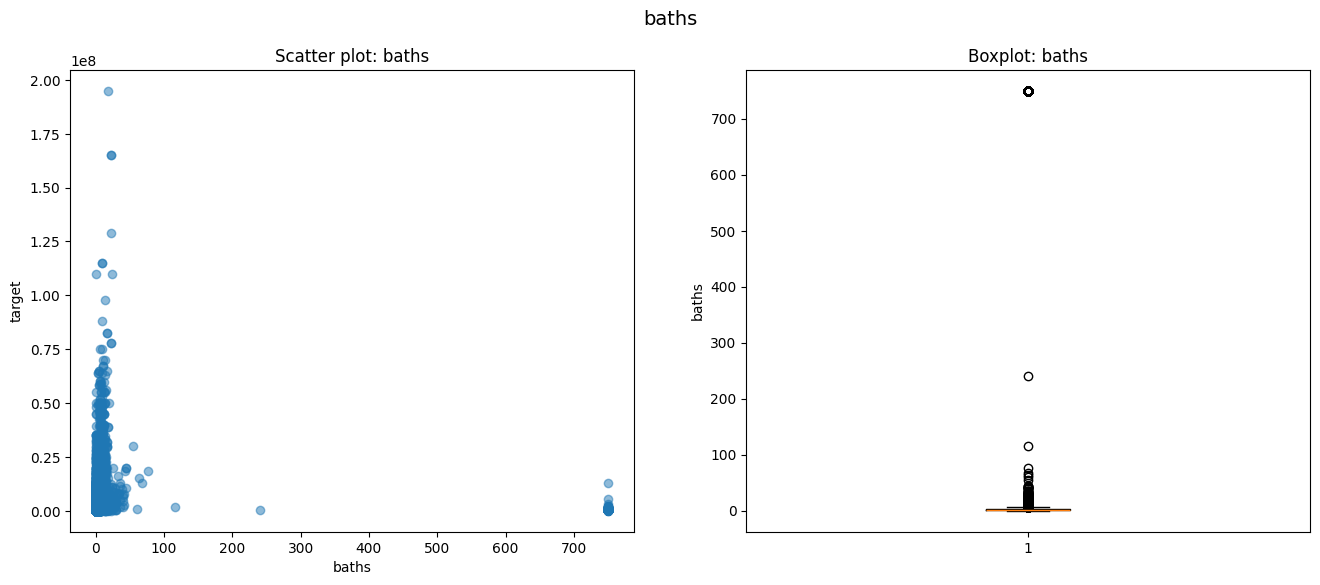

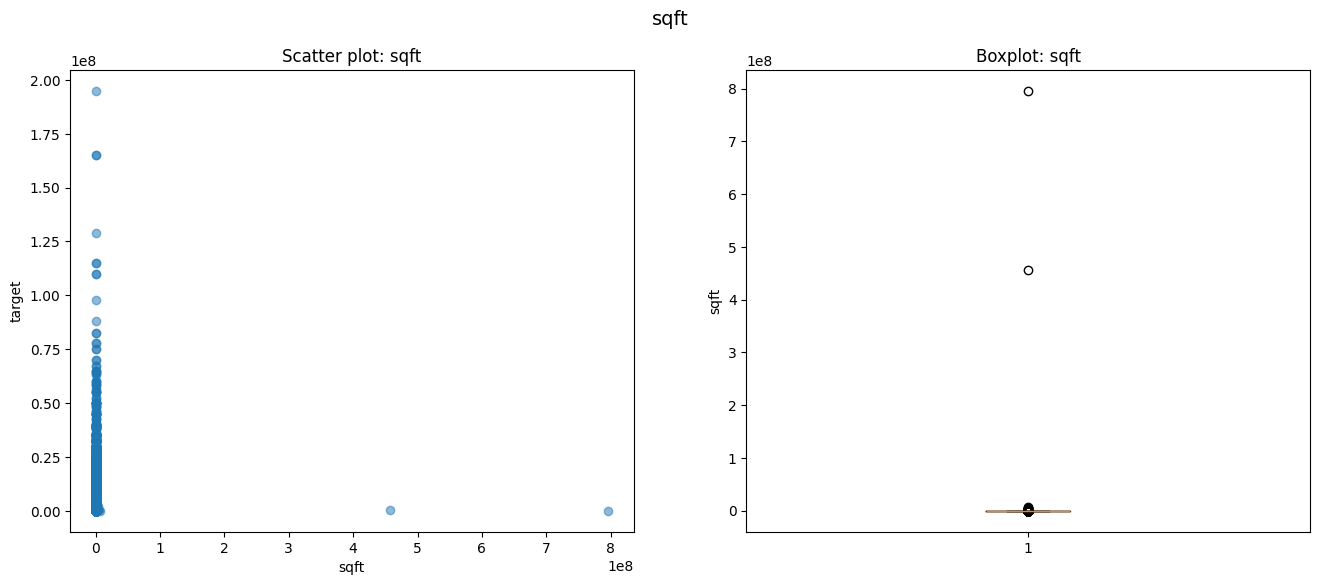

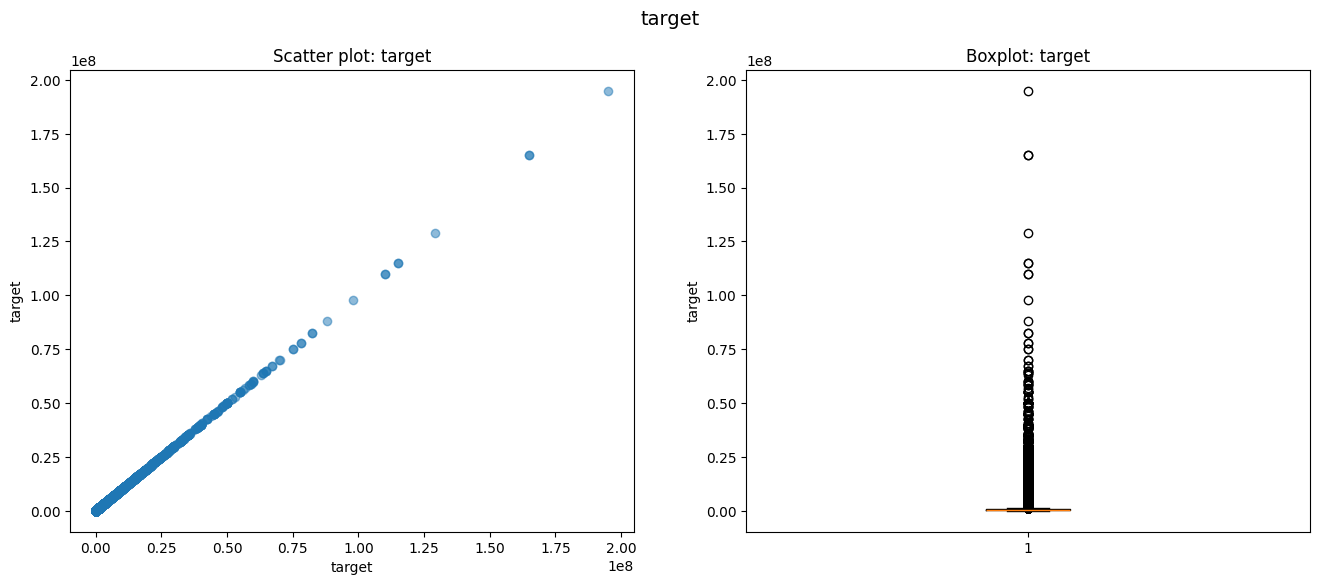

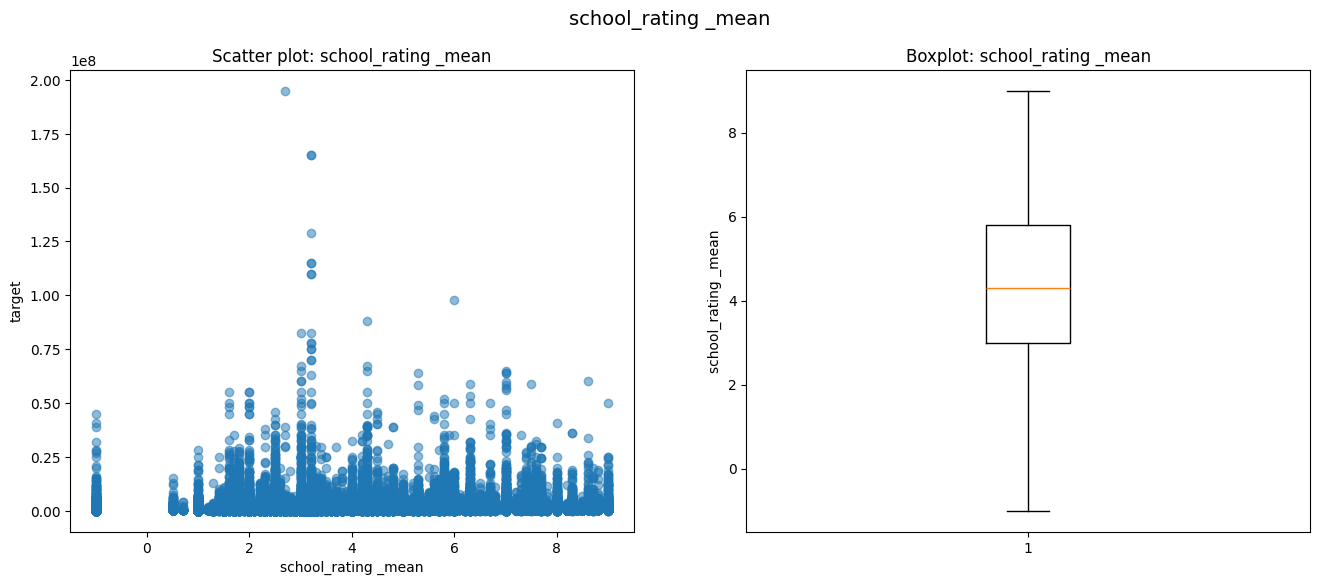

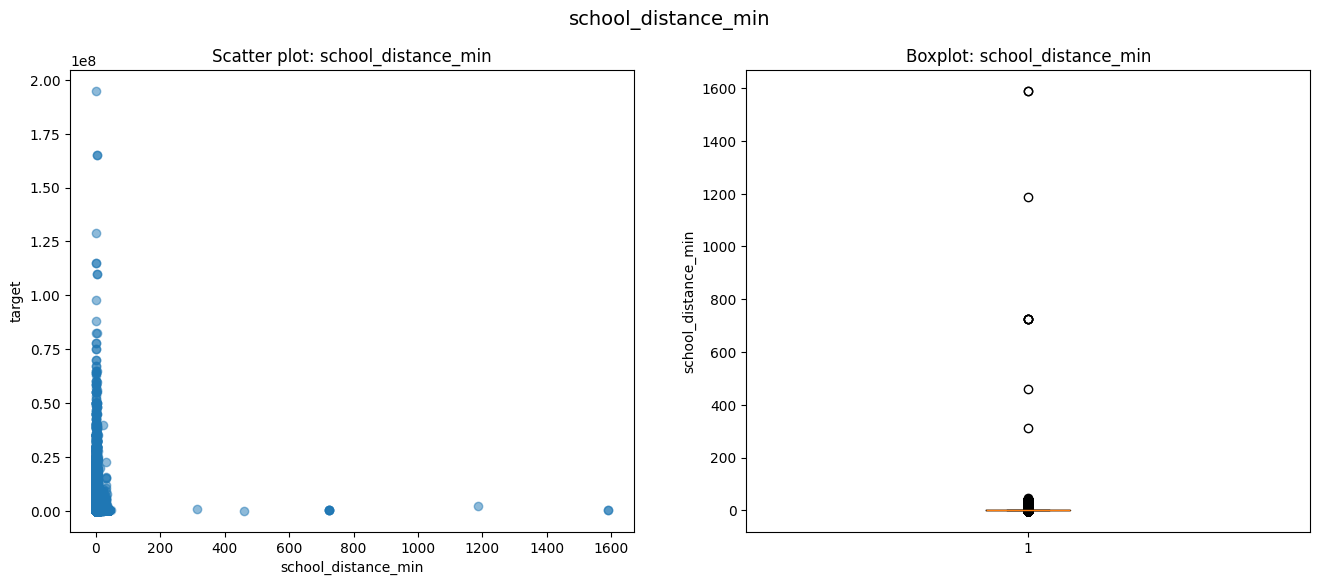

In [109]:
#Построение графиков для числовых признаков
for feature in numeric_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    #Диаграмма рассеивания
    ax1.scatter(df[feature], df['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    #Коробчатая диаграмма
    ax2.boxplot(df[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

В соответствии с построенными графиками очевидно наличие выбросов по признакам bath, sqft, school_distance_min. Данные нуждаются в дальнейшей обработке.

In [110]:
df['baths'].describe()

count    329233.000000
mean          2.718837
std          20.049123
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         750.000000
Name: baths, dtype: float64

In [111]:
#Поиск выбросов по признаку baths
condition = (df['baths'] > 100)
filtered_df = df[condition]

display(filtered_df.head(3))

average_sqft = filtered_df['sqft'].mean()

print(df[df['baths'] > 100].shape[0])

print("Среднее значение sqft: ", average_sqft)

,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
981,Active,750.0,Dallas,1758,75219,TX,499000,False,therest,1993,False,True,False,True,2.6,0.9
1788,Active,750.0,Washington,1367,20001,DC,1499000,False,therest,2013,False,False,False,False,6.8,0.3
3157,Active,750.0,Denver,873,80204,CO,348900,False,therest,1981,True,True,False,False,4.0,0.2


237
Среднее значение sqft:  2111.4725738396623


In [112]:
#Удаление выбросов, соответствующих условию выше
df.drop(df[condition].index, inplace=True)

In [113]:
display(df.head(5))
df.info()

,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
0,Active,4.0,Southern Pines,2900,28387,NC,418000,False,single_family_home,2019,True,False,False,True,5.2,2.70
1,For Sale,3.0,Spokane Valley,1947,99216,WA,310000,False,single_family_home,2019,False,False,False,False,4.0,1.01
2,For Sale,2.0,Los Angeles,3000,90049,CA,2895000,True,single_family_home,1961,True,True,True,True,6.7,1.19
3,For Sale,8.0,Dallas,6457,75205,TX,2395000,False,single_family_home,2006,True,True,True,True,5.6,0.10
4,For Sale,0.0,Philadelphia,897,19145,PA,209000,False,townhouse,1920,True,True,False,False,-1.0,-1.00


<class 'pandas.core.frame.DataFrame'>
Index: 328996 entries, 0 to 329232
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               328996 non-null  object 
 1   baths                328996 non-null  float64
 2   city                 328996 non-null  object 
 3   sqft                 328996 non-null  int64  
 4   zipcode              328996 non-null  object 
 5   state                328996 non-null  object 
 6   target               328996 non-null  int64  
 7   pool_corr            328996 non-null  bool   
 8   Typeofproperty       328996 non-null  object 
 9   Year built           328996 non-null  object 
 10  Heating_corr         328996 non-null  bool   
 11  Cooling_corr         328996 non-null  bool   
 12  Parking_corr         328996 non-null  bool   
 13  fireplace_corr       328996 non-null  bool   
 14  school_rating _mean  328996 non-null  float64
 15  school_distance_min  3

In [114]:
#Поиск выбросов по признаку sqft
condition1 = ((df['sqft'] == 0) & (df['target'] == 195000000)) | (df['sqft'] > 455000000)
filtered1_df = df[condition1]
display(filtered1_df)

,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
55231,For Sale,2.0,Cincinnati,795979430,45225,OH,27500,False,single_family_home,1901,True,True,True,True,2.5,0.78
116147,For Sale,18.0,Los Angeles,0,90077,CA,195000000,True,single_family_home,1935,True,True,True,True,2.7,1.30
328672,Active,0.0,Glendale,456602479,42740,KY,198000,False,multi_family_home,2012,True,True,False,False,6.3,3.10


In [115]:
#Удаление выбросов, соответствующих условию выше
df.drop(df[condition1].index, inplace=True)

In [116]:
display(df.head(2))
df.info()

,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
0,Active,4.0,Southern Pines,2900,28387,NC,418000,False,single_family_home,2019,True,False,False,True,5.2,2.70
1,For Sale,3.0,Spokane Valley,1947,99216,WA,310000,False,single_family_home,2019,False,False,False,False,4.0,1.01


<class 'pandas.core.frame.DataFrame'>
Index: 328993 entries, 0 to 329232
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               328993 non-null  object 
 1   baths                328993 non-null  float64
 2   city                 328993 non-null  object 
 3   sqft                 328993 non-null  int64  
 4   zipcode              328993 non-null  object 
 5   state                328993 non-null  object 
 6   target               328993 non-null  int64  
 7   pool_corr            328993 non-null  bool   
 8   Typeofproperty       328993 non-null  object 
 9   Year built           328993 non-null  object 
 10  Heating_corr         328993 non-null  bool   
 11  Cooling_corr         328993 non-null  bool   
 12  Parking_corr         328993 non-null  bool   
 13  fireplace_corr       328993 non-null  bool   
 14  school_rating _mean  328993 non-null  float64
 15  school_distance_min  3

In [117]:
#Поиск выбросов по признаку school_distance_min
condition2 = (df['school_distance_min'] > 200)
filtered2_df = df[condition2]
print(len(filtered2_df))
display(filtered2_df.head(2))

10


,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
23337,Therest,4.0,Falcon Heights,6000,78545,TX,670000,False,single_family_home,1980,True,True,True,False,2.5,312.40
96657,For Sale,0.0,Santa Ana,890,92703,TN,48640,False,single_family_home,1963,True,True,False,True,2.7,1590.36


In [118]:
#Удаление выбросов, соответствующих условию выше
df.drop(df[condition2].index, inplace=True)

In [119]:
display(df.head(5))
df.info()

,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
0,Active,4.0,Southern Pines,2900,28387,NC,418000,False,single_family_home,2019,True,False,False,True,5.2,2.70
1,For Sale,3.0,Spokane Valley,1947,99216,WA,310000,False,single_family_home,2019,False,False,False,False,4.0,1.01
2,For Sale,2.0,Los Angeles,3000,90049,CA,2895000,True,single_family_home,1961,True,True,True,True,6.7,1.19
3,For Sale,8.0,Dallas,6457,75205,TX,2395000,False,single_family_home,2006,True,True,True,True,5.6,0.10
4,For Sale,0.0,Philadelphia,897,19145,PA,209000,False,townhouse,1920,True,True,False,False,-1.0,-1.00


<class 'pandas.core.frame.DataFrame'>
Index: 328983 entries, 0 to 329232
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               328983 non-null  object 
 1   baths                328983 non-null  float64
 2   city                 328983 non-null  object 
 3   sqft                 328983 non-null  int64  
 4   zipcode              328983 non-null  object 
 5   state                328983 non-null  object 
 6   target               328983 non-null  int64  
 7   pool_corr            328983 non-null  bool   
 8   Typeofproperty       328983 non-null  object 
 9   Year built           328983 non-null  object 
 10  Heating_corr         328983 non-null  bool   
 11  Cooling_corr         328983 non-null  bool   
 12  Parking_corr         328983 non-null  bool   
 13  fireplace_corr       328983 non-null  bool   
 14  school_rating _mean  328983 non-null  float64
 15  school_distance_min  3

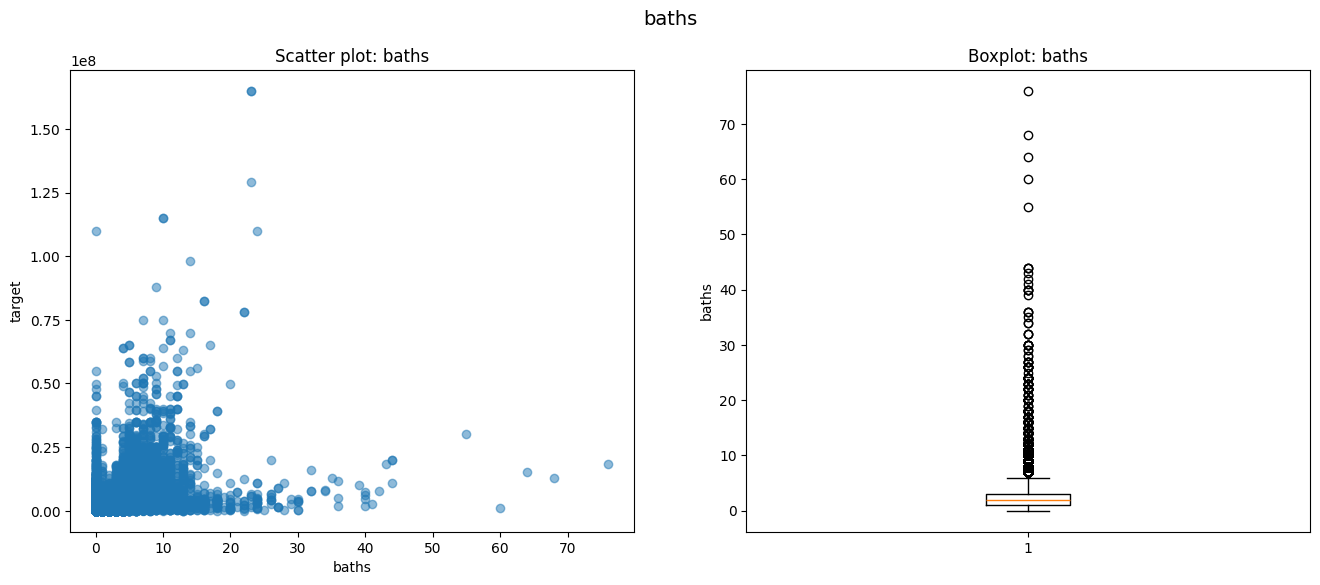

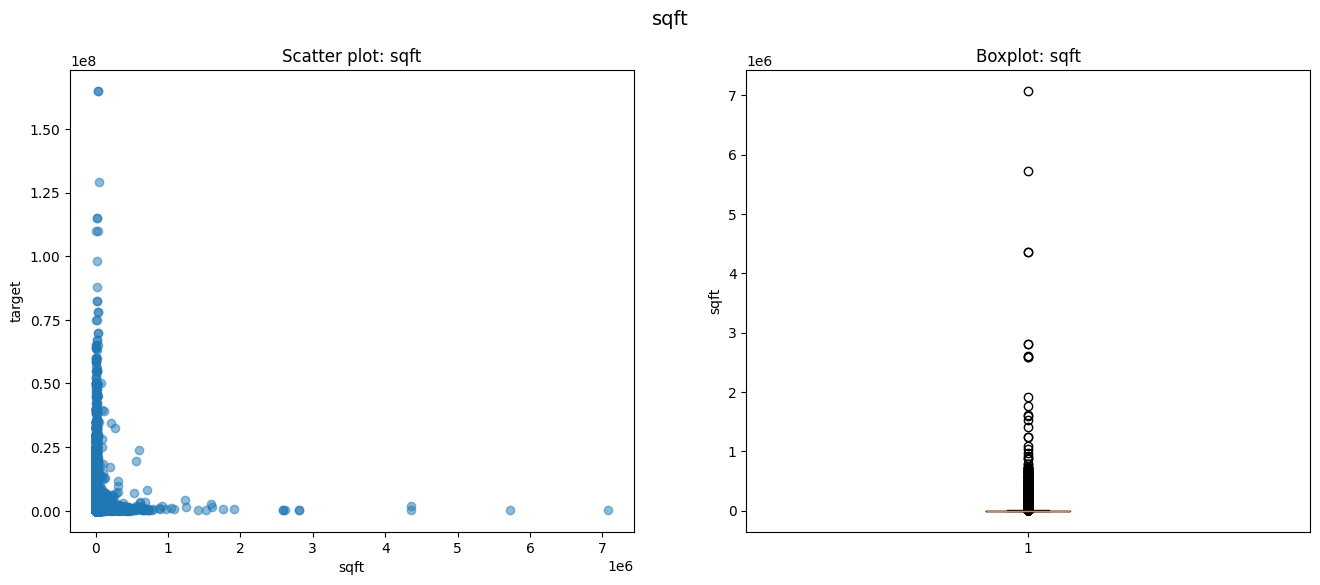

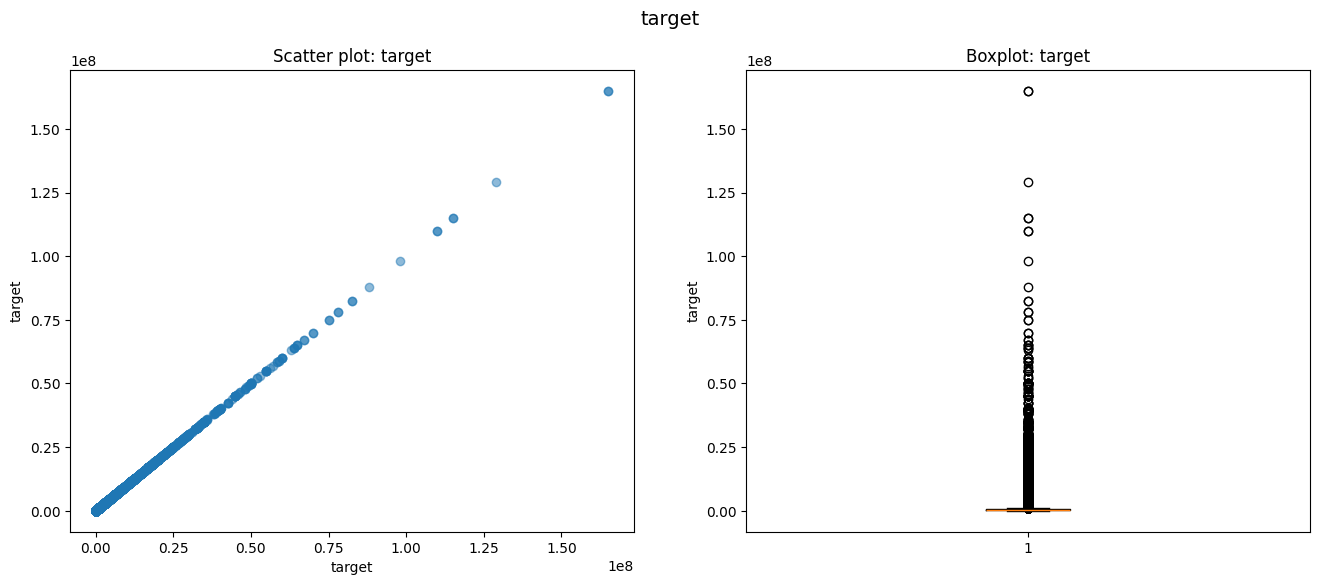

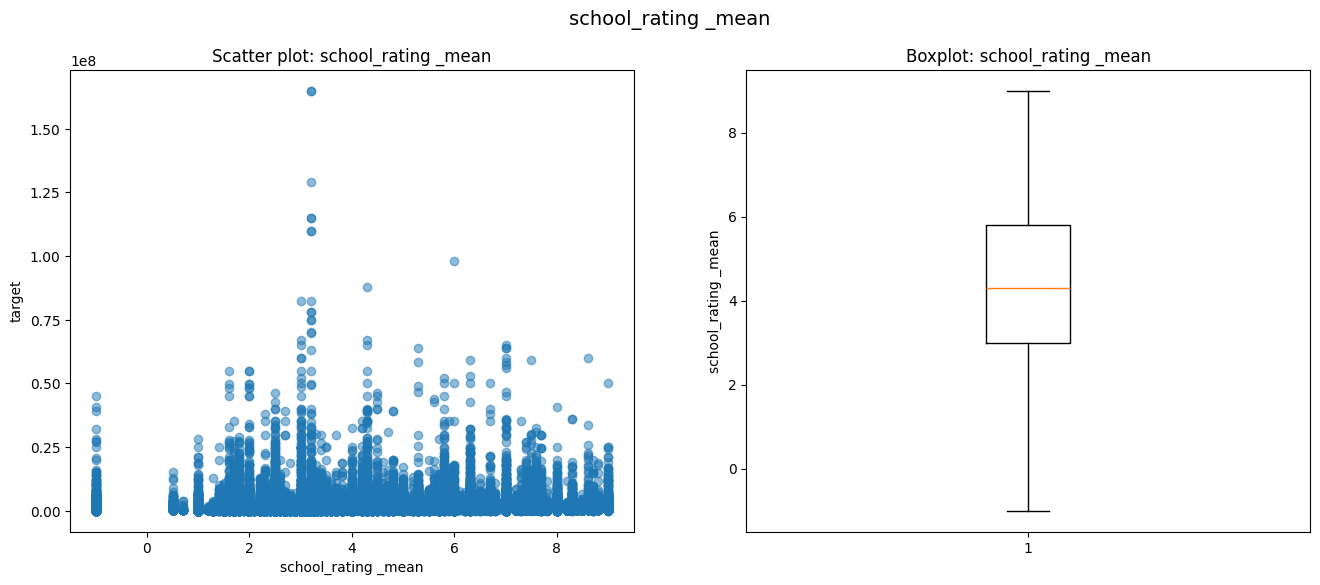

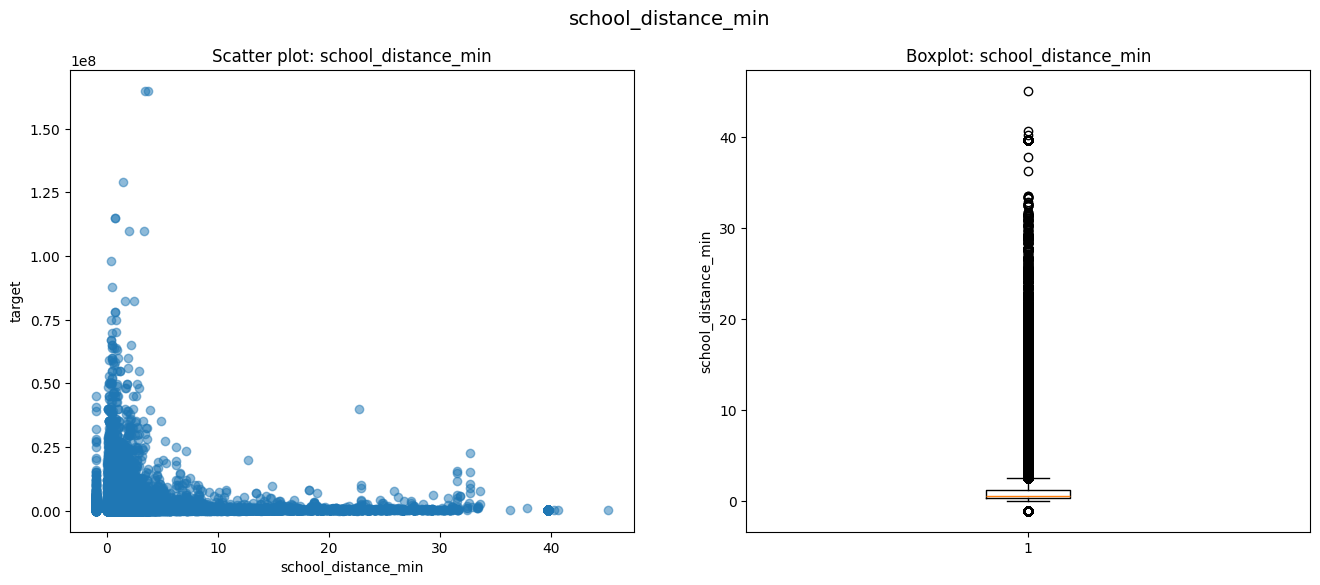

In [120]:
#Построение графиков для числовых признаков
for feature in numeric_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    #Диаграмма рассеивания
    ax1.scatter(df[feature], df['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    #Коробчатая диаграмма
    ax2.boxplot(df[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

Краткий вывод: исходя из полученных графиков, выбросы до сих пор присутствуют в датасете, необходимо повторно из обработать

In [121]:
#Поиск выбросов
condition3 = ((df['baths'] > 45) | (df['target'] > 850000)) | (df['sqft'] > 200000) |(df['school_distance_min']> 35)
filtered3_df = df[condition3]
print(len(filtered3_df))
display(filtered3_df.head(3))

49391


,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
2,For Sale,2.0,Los Angeles,3000,90049,CA,2895000,True,single_family_home,1961,True,True,True,True,6.7,1.19
3,For Sale,8.0,Dallas,6457,75205,TX,2395000,False,single_family_home,2006,True,True,True,True,5.6,0.10
14,For Sale,0.0,Brooklyn,0,11219,NY,1650000,False,single_family_home,1905,False,True,False,False,6.3,0.20


In [122]:
#Удаление выбросов, соответствующих условию выше
df.drop(df[condition3].index, inplace=True)

In [123]:
display(df.head(5))
df.info()

,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
0,Active,4.0,Southern Pines,2900,28387,NC,418000,False,single_family_home,2019,True,False,False,True,5.2,2.70
1,For Sale,3.0,Spokane Valley,1947,99216,WA,310000,False,single_family_home,2019,False,False,False,False,4.0,1.01
4,For Sale,0.0,Philadelphia,897,19145,PA,209000,False,townhouse,1920,True,True,False,False,-1.0,-1.00
5,Active,0.0,Poinciana,1507,34759,FL,181500,False,therest,2006,True,True,False,False,2.3,0.80
6,Active,0.0,Memphis,0,38115,TN,68000,False,therest,1976,False,False,False,False,2.7,0.40


<class 'pandas.core.frame.DataFrame'>
Index: 279592 entries, 0 to 329232
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               279592 non-null  object 
 1   baths                279592 non-null  float64
 2   city                 279592 non-null  object 
 3   sqft                 279592 non-null  int64  
 4   zipcode              279592 non-null  object 
 5   state                279592 non-null  object 
 6   target               279592 non-null  int64  
 7   pool_corr            279592 non-null  bool   
 8   Typeofproperty       279592 non-null  object 
 9   Year built           279592 non-null  object 
 10  Heating_corr         279592 non-null  bool   
 11  Cooling_corr         279592 non-null  bool   
 12  Parking_corr         279592 non-null  bool   
 13  fireplace_corr       279592 non-null  bool   
 14  school_rating _mean  279592 non-null  float64
 15  school_distance_min  2

In [124]:
condition4 = ((df['baths'] < 1) | (df['sqft'] < 1))
filtered4_df = df[condition4]
print(len(filtered4_df))
display(filtered4_df.head(3))

63064


,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
4,For Sale,0.0,Philadelphia,897,19145,PA,209000,False,townhouse,1920,True,True,False,False,-1.0,-1.0
5,Active,0.0,Poinciana,1507,34759,FL,181500,False,therest,2006,True,True,False,False,2.3,0.8
6,Active,0.0,Memphis,0,38115,TN,68000,False,therest,1976,False,False,False,False,2.7,0.4


In [125]:
#Удаление выбросов, соответствующих условию выше
df.drop(df[condition4].index, inplace=True)

In [126]:
display(df.head(5))
df.info()

,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
0,Active,4.0,Southern Pines,2900,28387,NC,418000,False,single_family_home,2019,True,False,False,True,5.2,2.70
1,For Sale,3.0,Spokane Valley,1947,99216,WA,310000,False,single_family_home,2019,False,False,False,False,4.0,1.01
7,Active,2.0,Mason,3588,50401,IA,244900,False,single_family_home,1970,True,True,False,False,3.8,5.60
8,Therest,3.0,Houston,1930,77080,TX,311995,False,single_family_home,2019,True,True,True,False,3.0,0.60
9,For Sale,2.0,Flushing,1300,11354,NY,669000,False,condo,1965,False,False,True,False,2.8,0.30


<class 'pandas.core.frame.DataFrame'>
Index: 216528 entries, 0 to 329232
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               216528 non-null  object 
 1   baths                216528 non-null  float64
 2   city                 216528 non-null  object 
 3   sqft                 216528 non-null  int64  
 4   zipcode              216528 non-null  object 
 5   state                216528 non-null  object 
 6   target               216528 non-null  int64  
 7   pool_corr            216528 non-null  bool   
 8   Typeofproperty       216528 non-null  object 
 9   Year built           216528 non-null  object 
 10  Heating_corr         216528 non-null  bool   
 11  Cooling_corr         216528 non-null  bool   
 12  Parking_corr         216528 non-null  bool   
 13  fireplace_corr       216528 non-null  bool   
 14  school_rating _mean  216528 non-null  float64
 15  school_distance_min  2

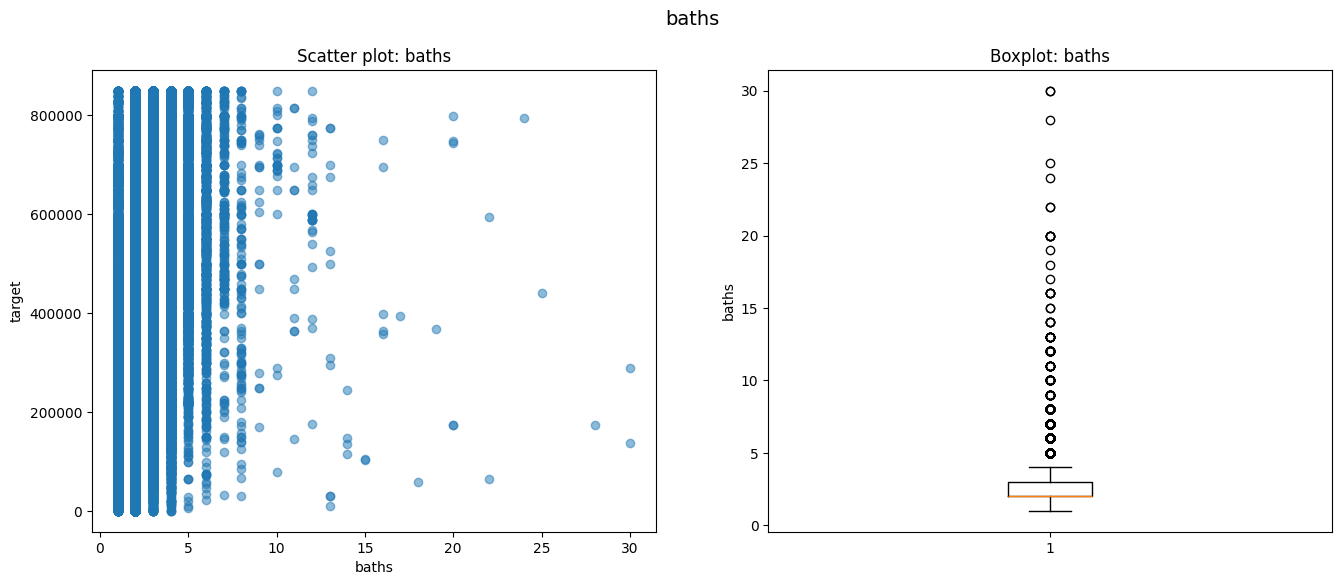

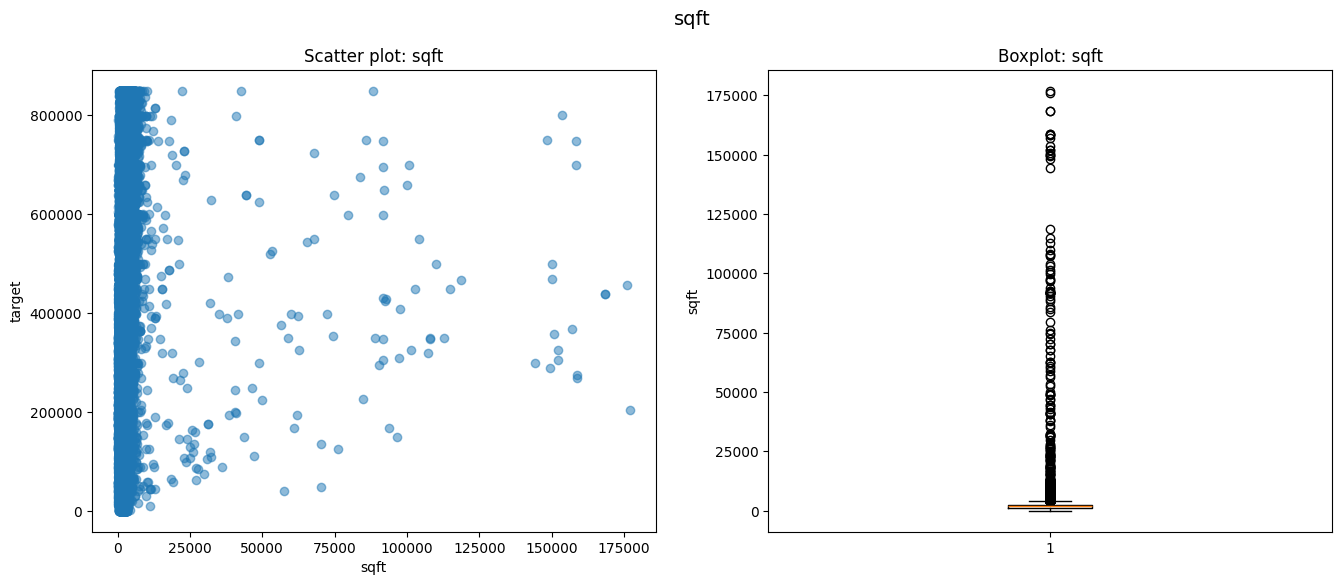

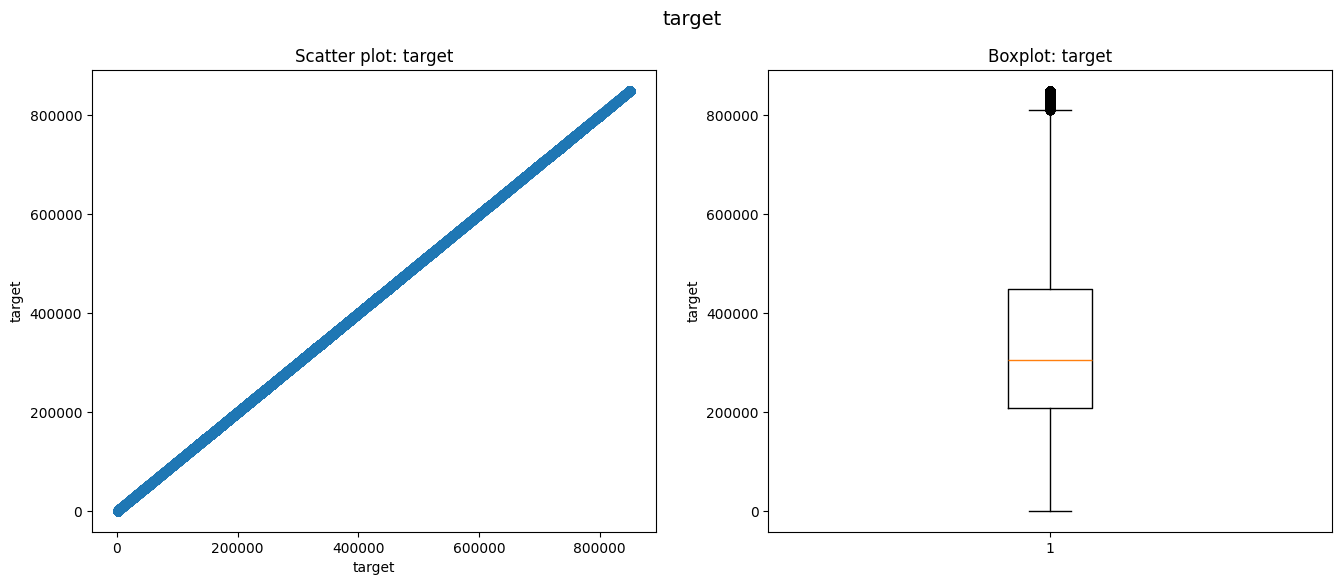

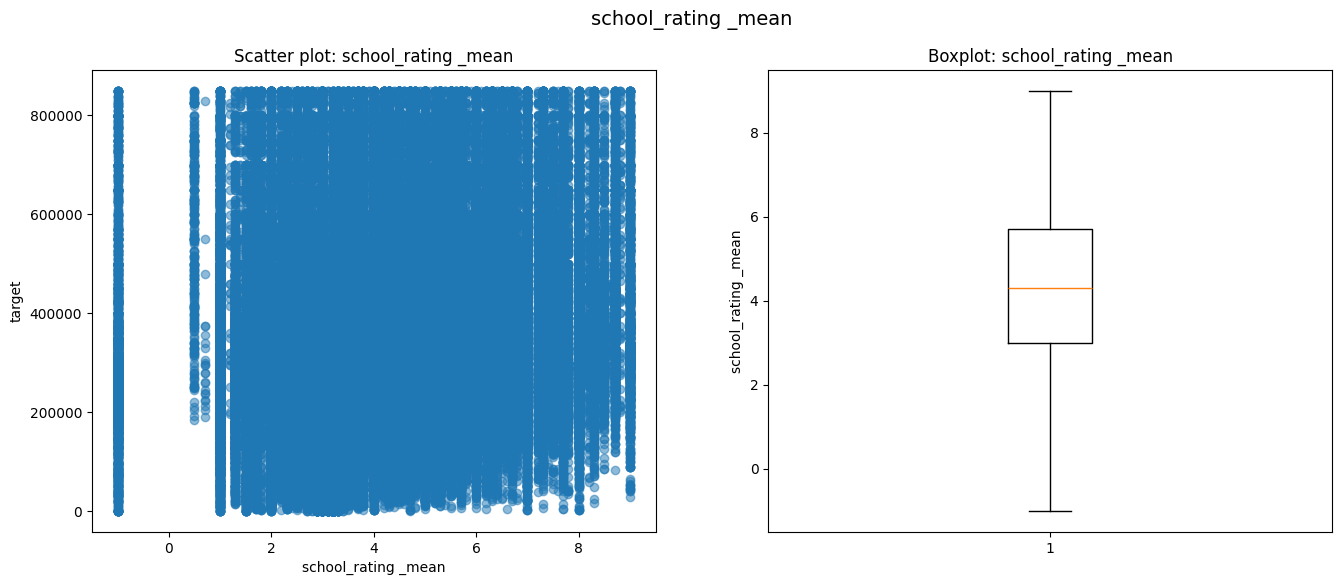

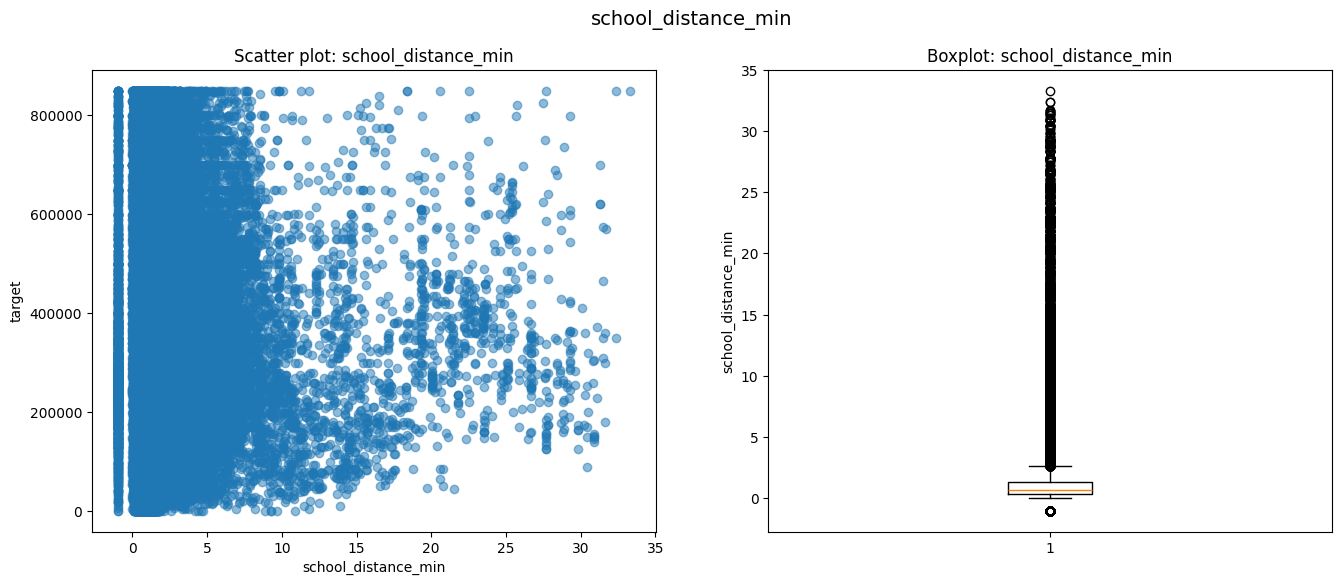

In [127]:
#Построение графиков для числовых признаков
for feature in numeric_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    #Диаграмма рассеивания
    ax1.scatter(df[feature], df['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    #Коробчатая диаграмма
    ax2.boxplot(df[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

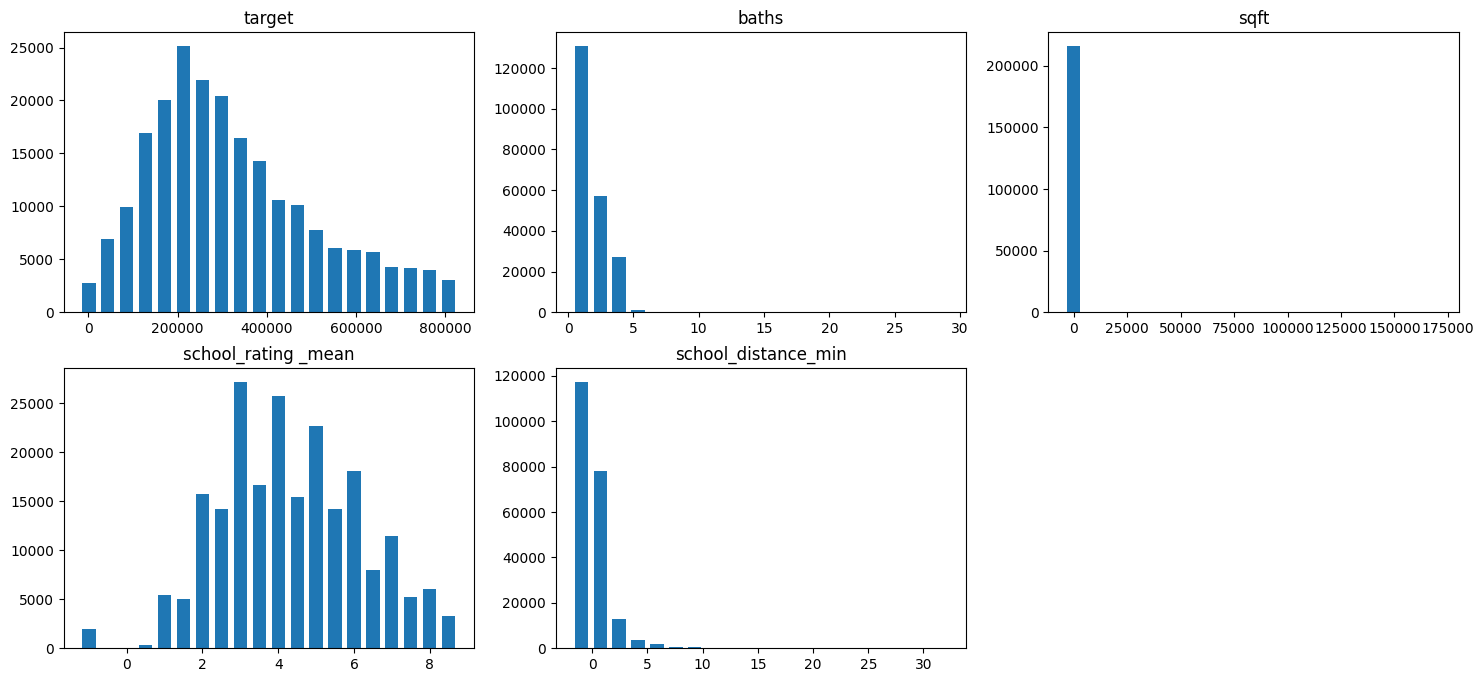

In [128]:
#Гистограмма для наглядности распределения числовых признаков
visualize_distributions({
    'target': df['target'],
    'baths': df['baths'],
    'sqft': df['sqft'],
    'school_rating _mean': df['school_rating _mean'],
    'school_distance_min': df['school_distance_min'],
})

Анализ категориальных признаков

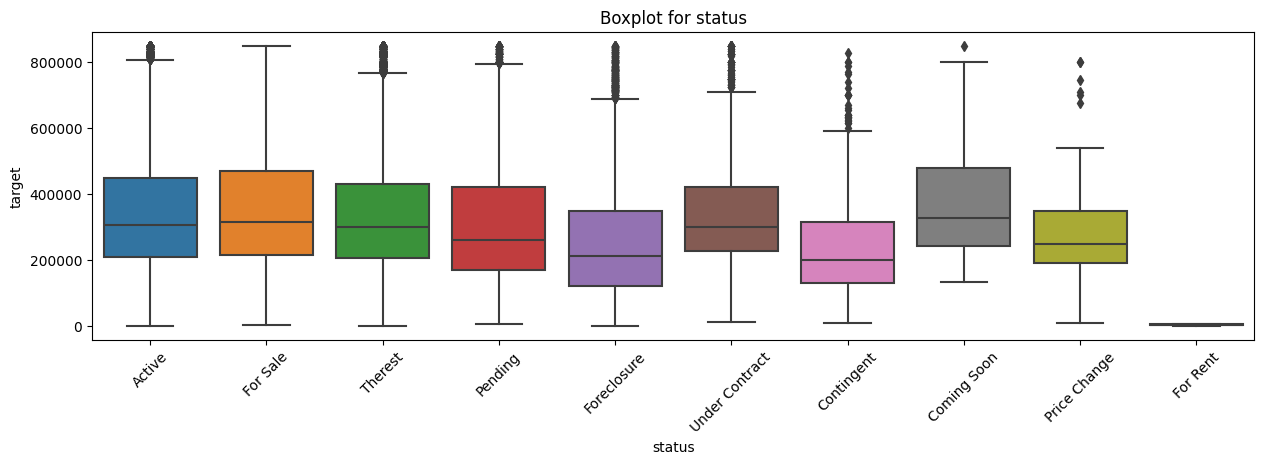

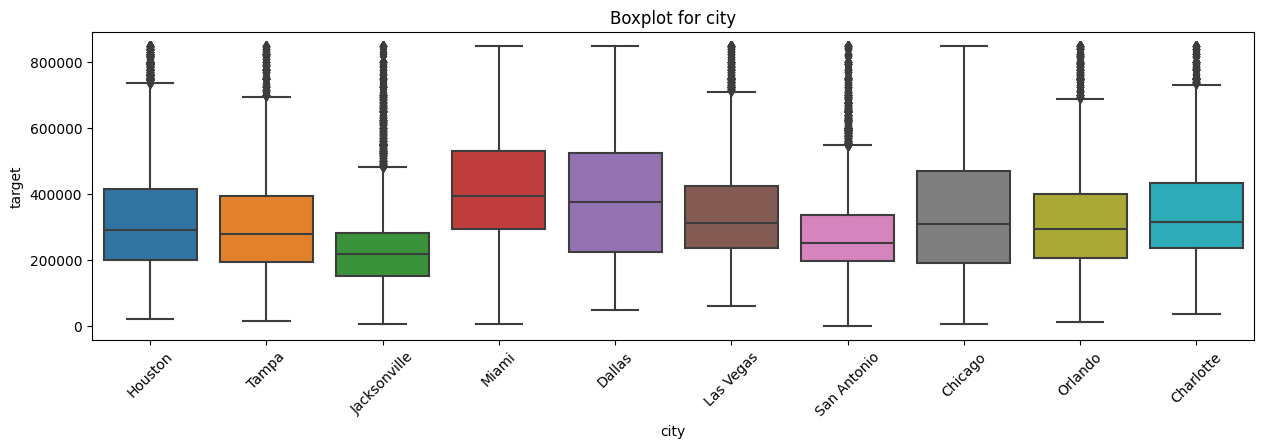

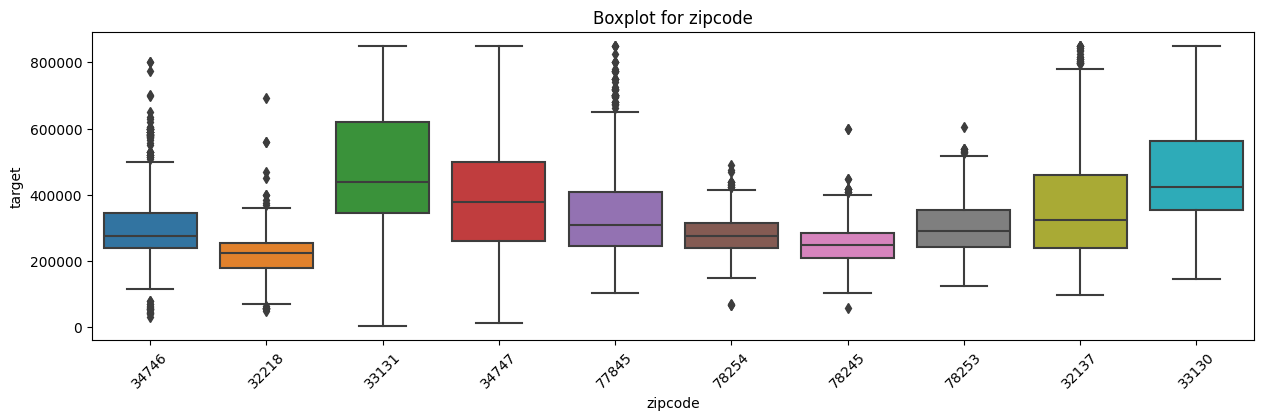

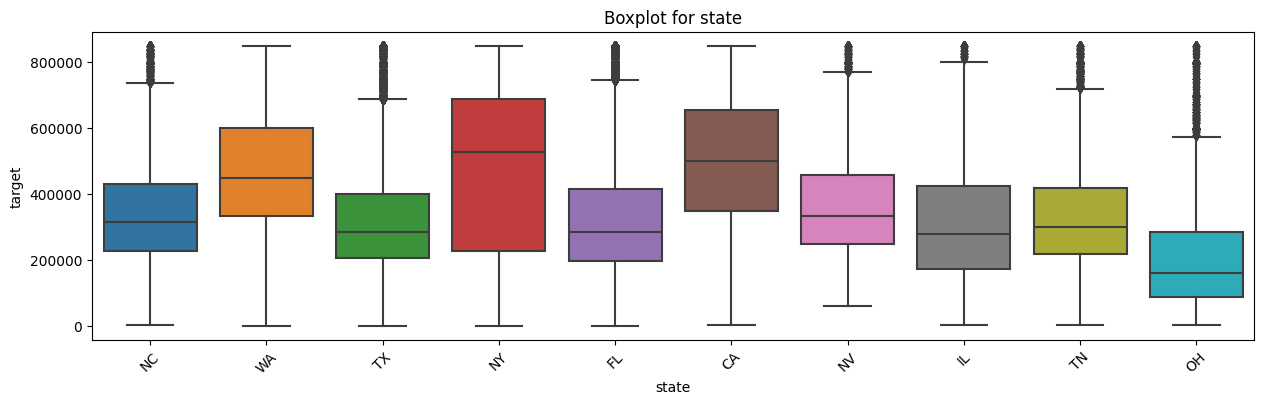

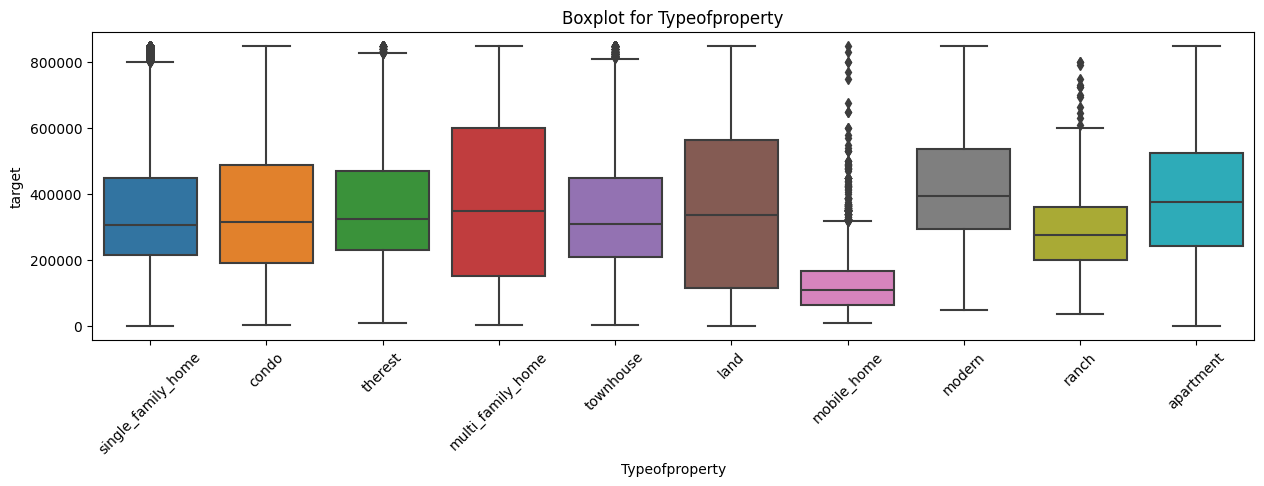

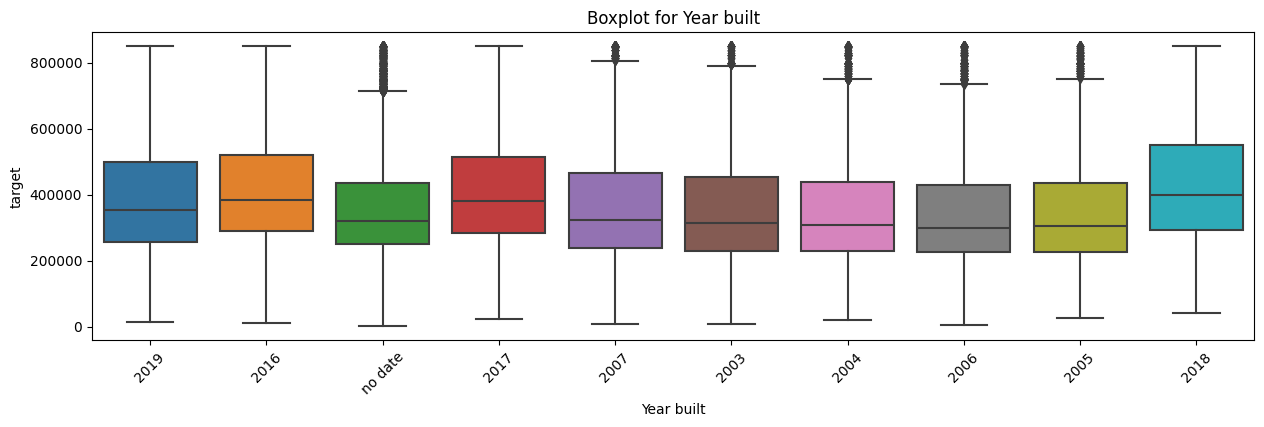

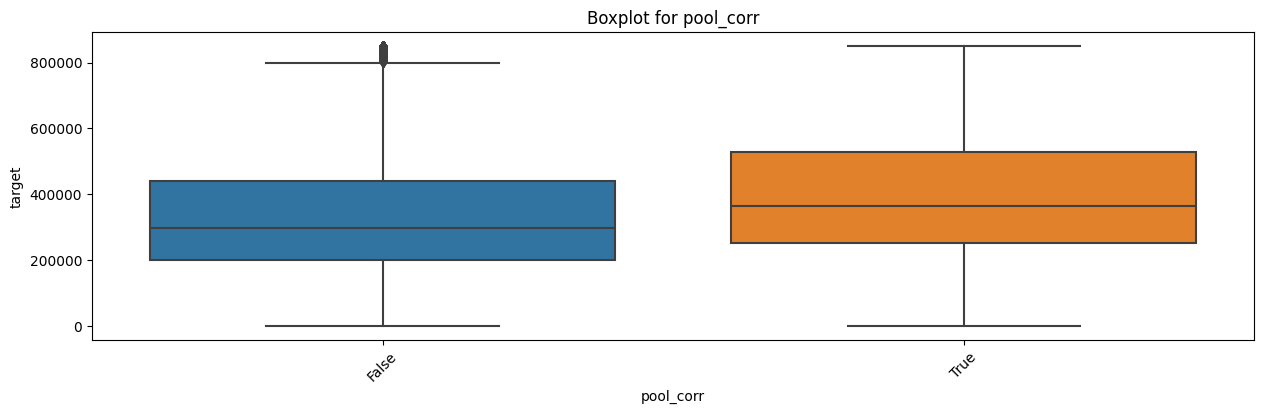

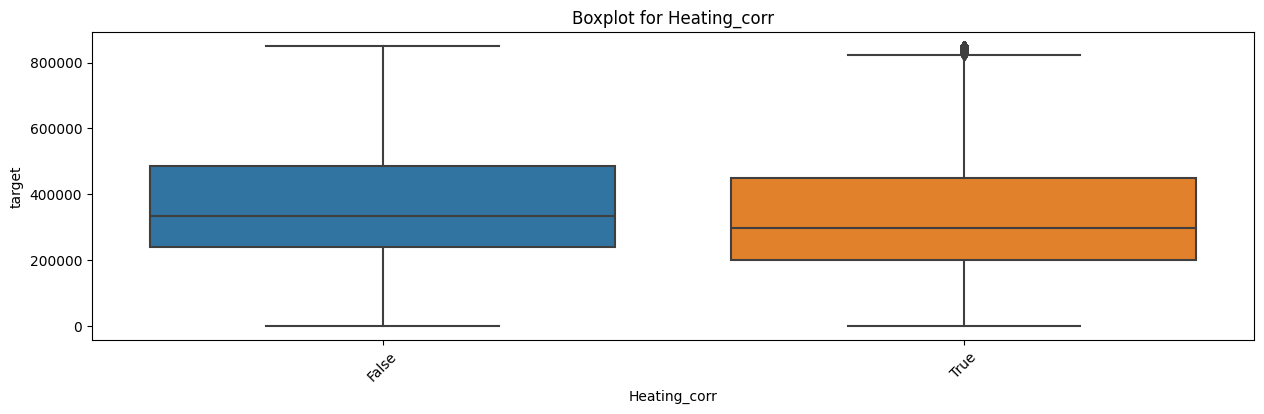

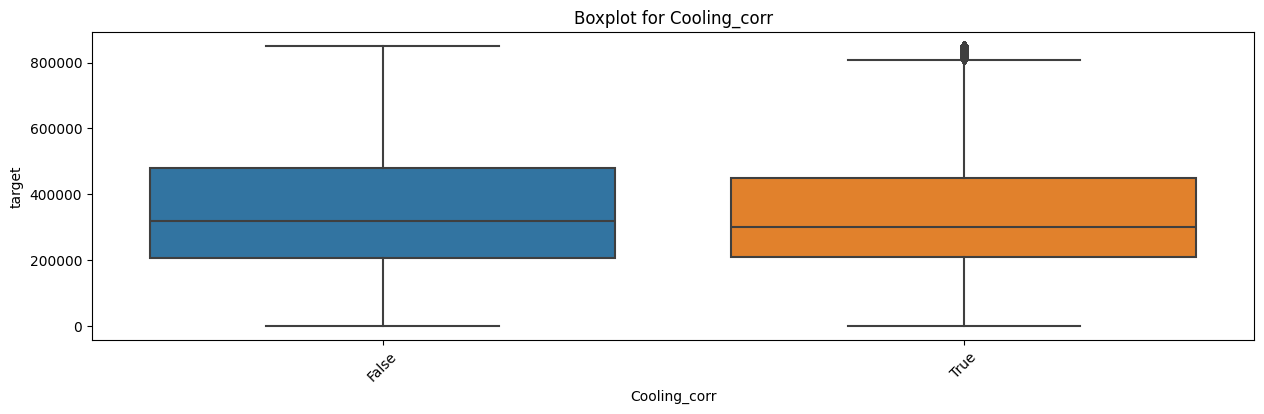

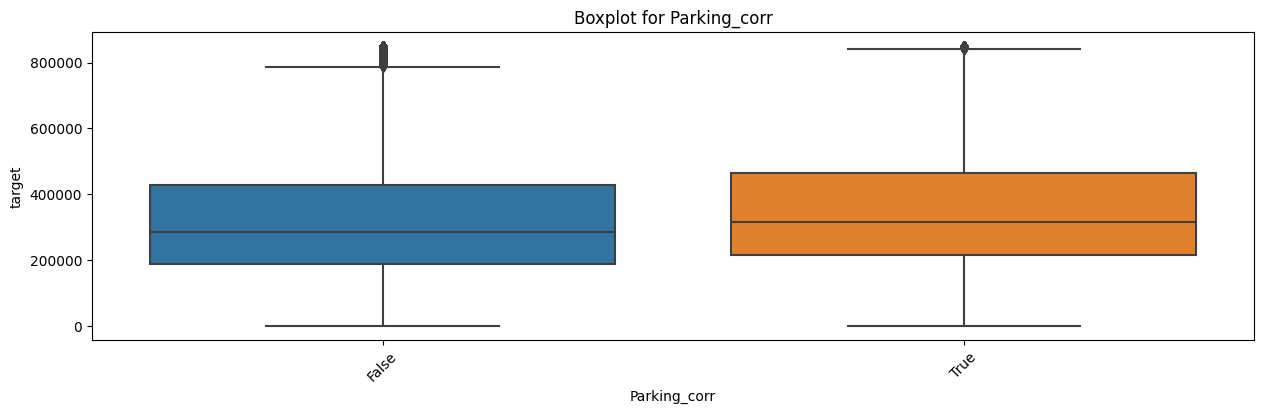

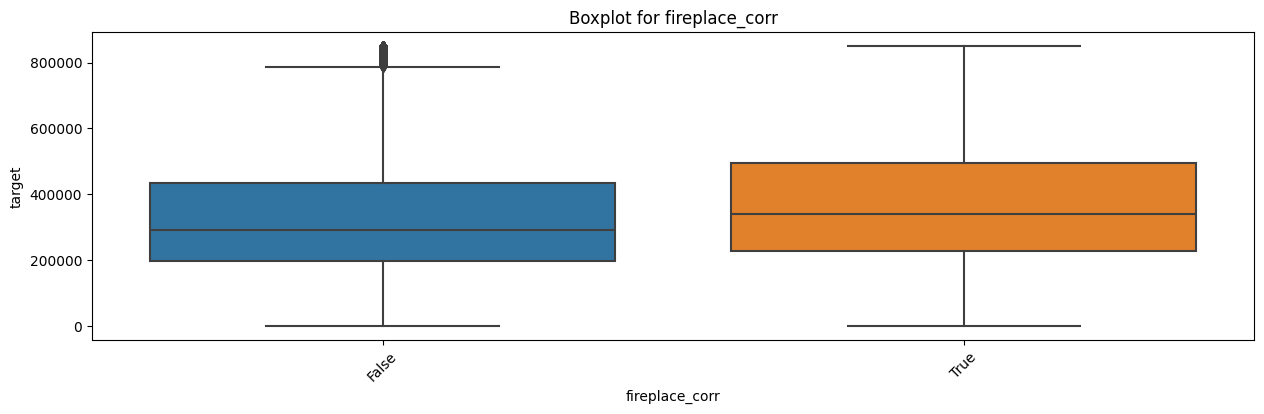

In [129]:
#Распределение стоимости квартир в зависимости от категориальных переменных
for col in chain(categorial_features, bul_features):
    get_boxplot(col)

Краткий вывод: Все признаки так или иначе влияют на стоимость недвижимости

Вывод: По итогам проведенного разведовательного анализа данных, было выполнено снижение размерности данных, а именно некоторые признаки были удалены, некоторые признаки были десериализованы и из них созданы новые признаки, некоторые предобработаны для дальнейшего анализа данных и поиска выбросов. С помощью визуализации были обнаружены и удалены выбросы и пропуски, которые влияют на целевую переменную.

In [130]:
df.to_csv('formodel_data.csv', index=False)

## 2. Поиск наиболее подходящей модели под поставленную задачу

In [131]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


Сгруппируем признаки по видам, обработаем, разделим датасет на обучающую и тестовую часть.

In [132]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
TEST_SIZE = 0.2

In [133]:
df = pd.read_csv('formodel_data.csv')
display(df.head(3))
df.info()

,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
0,Active,4.0,Southern Pines,2900,28387,NC,418000,False,single_family_home,2019,True,False,False,True,5.2,2.70
1,For Sale,3.0,Spokane Valley,1947,99216,WA,310000,False,single_family_home,2019,False,False,False,False,4.0,1.01
2,Active,2.0,Mason,3588,50401,IA,244900,False,single_family_home,1970,True,True,False,False,3.8,5.60


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216528 entries, 0 to 216527
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               216528 non-null  object 
 1   baths                216528 non-null  float64
 2   city                 216528 non-null  object 
 3   sqft                 216528 non-null  int64  
 4   zipcode              216528 non-null  int64  
 5   state                216528 non-null  object 
 6   target               216528 non-null  int64  
 7   pool_corr            216528 non-null  bool   
 8   Typeofproperty       216528 non-null  object 
 9   Year built           216528 non-null  object 
 10  Heating_corr         216528 non-null  bool   
 11  Cooling_corr         216528 non-null  bool   
 12  Parking_corr         216528 non-null  bool   
 13  fireplace_corr       216528 non-null  bool   
 14  school_rating _mean  216528 non-null  float64
 15  school_distance_m

In [134]:
#Определение списка булевых признаков:
bul_features = ['pool_corr','Heating_corr','Cooling_corr','Parking_corr','fireplace_corr']

#Определение списка категориальных признаков:
categorial_features = ['status','city','zipcode','state','Typeofproperty','Year built']
 
#Определение списка числовых признаков:
numeric_features = ['baths', 'sqft', 'target', 'school_rating _mean', 'school_distance_min']

In [135]:
#Определение количества уникальных значений в каждом категориальном признаке
for col in categorial_features:
   unique_values = df[col].nunique()
   print(f"Количество уникальных значений в категориальной колонке {col}: {unique_values}")

Количество уникальных значений в категориальной колонке status: 10
Количество уникальных значений в категориальной колонке city: 1537
Количество уникальных значений в категориальной колонке zipcode: 3981
Количество уникальных значений в категориальной колонке state: 34
Количество уникальных значений в категориальной колонке Typeofproperty: 12
Количество уникальных значений в категориальной колонке Year built: 206


In [136]:
def preproc_data(df_input):
    
    df_output = df_input.copy()
    #Zipcode в категориальный
    df_output['zipcode'] = df_output['zipcode'].astype(str)
    #Year built в категориальный
    df_output['Year built'] = df_output['Year built'].astype(str)
    # Нормализация данных
    for column in ['baths', 'sqft', 'target', 'school_rating _mean', 'school_distance_min']:
       
        df_output[column] = df_output[column].apply(lambda x: abs(x))
        constant = 1e-6
        df_output[column] = np.log(df_output[column] + constant)
        
 
    ohe_status = OneHotEncoder(sparse=False)
    ohe_state = OneHotEncoder(sparse=False)
    ohe_Type = OneHotEncoder(sparse=False)

    status_ohe = ohe_status.fit_transform(df_output['status'].values.reshape(-1,1))
    state_ohe = ohe_state.fit_transform(df_output['state'].values.reshape(-1,1))
    Type_ohe = ohe_Type.fit_transform(df_output['Typeofproperty'].values.reshape(-1,1))

    le = LabelEncoder()
    state_label = le.fit_transform(df_output['state'])

    year_le = LabelEncoder()
    year_ord = year_le.fit_transform(df_output['Year built'])

    city_le = LabelEncoder()
    city_label = city_le.fit_transform(df_output['city'])

    zip_le = LabelEncoder()
    zip_label = zip_le.fit_transform(df_output['zipcode'])

    #Добавление нормализованных категориальных объектов в базу данных
    df_output = df_output.join(pd.DataFrame(status_ohe, columns=['status_' + str(cat) for cat in ohe_status.categories_[0]]))
    df_output = df_output.join(pd.DataFrame(state_ohe, columns=['state_' + str(cat) for cat in ohe_state.categories_[0]]))
    df_output = df_output.join(pd.DataFrame(Type_ohe, columns=['Typeofproperty_' + str(cat) for cat in ohe_Type.categories_[0]]))
    df_output['state_label'] = state_label
    df_output['year_ord'] = year_ord
    df_output['city_label'] = city_label
    df_output['zip_label'] = zip_label

    #Удаление неактуальных категориальных признаков
    df_output.drop(['status', 'state', 'Typeofproperty', 'city', 'zipcode','Year built'], axis=1, inplace=True)
    
    return df_output

In [137]:
df_encoded = preproc_data(df)
df_encoded.sample(10)

c:\Users\livia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\livia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\livia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,baths,sqft,target,pool_corr,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min,...,Typeofproperty_modern,Typeofproperty_multi_family_home,Typeofproperty_ranch,Typeofproperty_single_family_home,Typeofproperty_therest,Typeofproperty_townhouse,state_label,year_ord,city_label,zip_label
104489,9.999995e-07,6.601230,11.982304,False,True,True,False,False,1.740466,-1.203969,...,0.0,0.0,0.0,0.0,0.0,0.0,5,151,584,1028
59118,6.931477e-01,6.401917,13.610943,False,False,True,False,False,1.609438,-1.237871,...,0.0,0.0,0.0,0.0,0.0,0.0,21,202,167,107
30205,1.098613e+00,7.802209,12.945626,True,True,True,True,True,1.791760,-0.916288,...,0.0,0.0,0.0,1.0,0.0,0.0,28,167,328,2330
99055,1.386295e+00,8.169903,12.660328,True,True,True,True,True,1.252763,0.262365,...,0.0,0.0,0.0,1.0,0.0,0.0,27,170,305,1433
101069,9.999995e-07,6.837333,12.206787,False,True,True,True,False,2.014903,-1.203969,...,0.0,0.0,0.0,1.0,0.0,0.0,5,165,993,1003
182602,1.098613e+00,7.894318,13.335861,False,True,True,True,True,0.955512,-0.916288,...,0.0,0.0,0.0,1.0,0.0,0.0,27,203,907,1358
144796,1.098613e+00,7.990915,13.300056,True,True,True,True,True,1.840550,-1.609433,...,0.0,0.0,0.0,1.0,0.0,0.0,28,146,328,2318
72099,6.931477e-01,7.628031,13.171154,False,True,False,False,False,1.945910,0.463735,...,0.0,0.0,0.0,1.0,0.0,0.0,24,75,1074,3768
64431,1.098613e+00,7.247793,12.116695,False,True,True,True,False,1.791760,-0.314709,...,0.0,0.0,0.0,0.0,0.0,0.0,28,187,286,2604
67170,1.098613e+00,7.404888,12.524526,False,False,False,False,False,1.609438,0.157005,...,0.0,0.0,0.0,0.0,0.0,0.0,18,185,51,785


In [138]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216528 entries, 0 to 216527
Data columns (total 70 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   baths                              216528 non-null  float64
 1   sqft                               216528 non-null  float64
 2   target                             216528 non-null  float64
 3   pool_corr                          216528 non-null  bool   
 4   Heating_corr                       216528 non-null  bool   
 5   Cooling_corr                       216528 non-null  bool   
 6   Parking_corr                       216528 non-null  bool   
 7   fireplace_corr                     216528 non-null  bool   
 8   school_rating _mean                216528 non-null  float64
 9   school_distance_min                216528 non-null  float64
 10  status_Active                      216528 non-null  float64
 11  status_Coming Soon                 2165

In [139]:
#Разбивка датасета на обучающую и тестовую выборки

y = df_encoded.target.values
X = df_encoded.drop(['target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

# 2. Разработка модели

### 1. LinearRegression

In [140]:
#Создание модели линейной регрессии
model = LinearRegression(fit_intercept=False)

#Обучение модели
model.fit(X_train, y_train)

#Предсказания на обучающих и тестовых данных
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

#Метрики качества модели
mse_train = metrics.mean_squared_error(y_train, y_train_pred)
mse_test = metrics.mean_squared_error(y_test, y_test_pred)
mae_train = metrics.mean_absolute_error(y_train, y_train_pred)
mae_test = metrics.mean_absolute_error(y_test, y_test_pred)
r2_train = metrics.r2_score(y_train, y_train_pred)
r2_test = metrics.r2_score(y_test, y_test_pred)

print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.24
Test MSE: 0.25
Train MAE: 0.35
Test MAE: 0.35
Train R2: 0.46
Test R2: 0.46


Низкие значения MSE, MAE указывают на достаточно точные предсказания модели.

Коэффициент детерминации (R2) В данном случае R2 составляет 0.46 как для обучающей, так и для тестовой выборки, что означает, что модель объясняет 46% дисперсии зависимой переменной.

Результаты модели показывают, что она работает с одинаковой точностью на обучающем и тестовом наборе данных, что свидетельствует о том, что модель не переобучилась. Однако, коэффициент детерминации R2 достаточно высокий.

### 2. RandomForestRegressor

In [141]:
#Создание модели RandomForestRegressor
regressor = RandomForestRegressor(random_state=RANDOM_SEED)

#Обучение модели
regressor.fit(X_train, y_train)

#Предсказания на обучающих и тестовых данных
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

#Метрики качества модели
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)


print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.01
Test MSE: 0.07
Train MAE: 0.06
Test MAE: 0.17
Train R2: 0.98
Test R2: 0.85


Значения MSE для обучающей выборки  0.01 и 0.07 для тестовой выборки может указывать на небольшое переобучение модели.

Значения MAE для обучающей выборки 0.06 и 0.17 для тестовой выборки может указывать на небольшое переобучение модели.

Коэффициент детерминации R2 равеный 0.98 для обучающей выборки и 0.85 для тестовой выборки указывают на то, что модель довольно хорошо работает на обучающей выборке и достаточно хорошо предсказывает на тестовой выборке, однако значение R2 на тестовой выборке заметно ниже, что также может указывать на небольшое переобучение модели.

Модель достаточно эффективна.

### Модель 3: ElasticNetCV

In [142]:
#Создание модели ElasticNetCV 
model_el = ElasticNetCV(cv=5, random_state=RANDOM_SEED)
model_el.fit(X_train, y_train)

##Предсказания на обучающих и тестовых данных
y_train_pred = model_el.predict(X_train)
y_test_pred = model_el.predict(X_test)

#Метрики качества модели
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.39
Test MSE: 0.40
Train MAE: 0.46
Test MAE: 0.46
Train R2: 0.12
Test R2: 0.12


Значения MSE для обучающей выборки 0.39 и 0.40 для тестовой выборки указывают на то, что можель не переобучилась, однако не достаточно эффективна из-за высоких показателей ошибок.

Значения MAE для обучающей и тестовой выборки 0.46, что означает, что в среднем модель ошибается на 0.46 при предсказаниях.

Коэффициент детерминации R2 равеный 0.12 для обучающей и тестовой выборки, свидетельствует о невысоком качестве модели.


ИТОГО:

In [143]:
data = {'Metric': ['Train MSE', 'Test MSE', 'Train MAE', 'Test MAE', 'Train R2', 'Test R2'],
        'LinearRegression': [0.24, 0.25, 0.35, 0.35, 0.46, 0.46],
        'RandomForestRegressor': [0.01, 0.07, 0.06, 0.17, 0.98, 0.85],
        'ElasticNetCV': [0.39, 0.40, 0.46, 0.46, 0.12, 0.12]}

df_metric = pd.DataFrame(data)
df_metric.head(6)

,Metric,LinearRegression,RandomForestRegressor,ElasticNetCV
0,Train MSE,0.24,0.01,0.39
1,Test MSE,0.25,0.07,0.40
2,Train MAE,0.35,0.06,0.46
3,Test MAE,0.35,0.17,0.46
4,Train R2,0.46,0.98,0.12
5,Test R2,0.46,0.85,0.12


## Вывод: Основываясь на полученных результатах модель RandomForestRegressor является самой оптимальной для решения поставленной задачи, ввиду наименьших показателей ошибок MSE и MAE, вместе с высоким коэффициентом детерминации R2 (0.85) на тестовых данных.

In [144]:
df.head()

,status,baths,city,sqft,zipcode,state,target,pool_corr,Typeofproperty,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
0,Active,4.0,Southern Pines,2900,28387,NC,418000,False,single_family_home,2019,True,False,False,True,5.2,2.70
1,For Sale,3.0,Spokane Valley,1947,99216,WA,310000,False,single_family_home,2019,False,False,False,False,4.0,1.01
2,Active,2.0,Mason,3588,50401,IA,244900,False,single_family_home,1970,True,True,False,False,3.8,5.60
3,Therest,3.0,Houston,1930,77080,TX,311995,False,single_family_home,2019,True,True,True,False,3.0,0.60
4,For Sale,2.0,Flushing,1300,11354,NY,669000,False,condo,1965,False,False,True,False,2.8,0.30


In [145]:

import pickle

In [146]:
model_m = pickle.dumps(regressor)
print(type(model_m))
print(type(regressor))

<class 'bytes'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>


In [147]:
# Сохранение выбранной обученной модели в файл pickle для дальнейшей передачи в деплой.
with open('regressor.pkl', 'wb') as output: 
    pickle.dump(regressor, output)